# ロジスティック回帰分析

説明変数（cpNum, cpNum_range, cpNum_dir, tree）と目的変数（バグ発見の有無、タイムアウトの有無など）のロジスティック回帰分析を実行します。

## 分析可能な内容

1. **バグ発見の有無（二値分類）**: パラメータからバグ発見確率を予測
2. **タイムアウトの有無（二値分類）**: パラメータからタイムアウト確率を予測
3. **バグ発見数のカテゴリ分類（多クラス分類）**: パラメータからバグ発見数のカテゴリを予測
4. **実行結果の分類（多クラス分類）**: パラメータから実行結果（正常終了、バグ発見、タイムアウト）を予測


In [573]:
# 必要なライブラリのインポート
import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm
import seaborn as sns
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
# 日本語フォント設定
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 可能であれば日本語フォントを設定
try:
    if os.name == 'posix':  # Mac/Linux
        japanese_fonts = ['Hiragino Sans', 'Hiragino Kaku Gothic Pro', 'Yu Gothic', 'Meiryo']
        for font in japanese_fonts:
            try:
                plt.rcParams['font.family'] = font
                break
            except:
                continue
except:
    pass

# 図のサイズ設定
plt.rcParams['figure.figsize'] = (10, 6)

print("ライブラリのインポートが完了しました")


ライブラリのインポートが完了しました


In [574]:
# データ収集関数（既存の分析から再利用）
def parse_directory_name(dir_name):
    """
    ディレクトリ名をパースしてcpNum, cpNum_range, cpNum_dirを抽出
    
    Args:
        dir_name: ディレクトリ名（例: "0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1"）
    
    Returns:
        tuple: (cpNum, cpNum_range, cpNum_dir) または (None, None, None)
    """
    params = dir_name.split(',')
    if len(params) < 30:
        return None, None, None
    
    try:
        cpnum = None
        cpnum_range = None
        cpnum_dir = None
        
        # cpNum (0-9番目)
        for i in range(10):
            if int(params[i]) != 0:
                cpnum = int(params[i])
                break
        
        # cpNum_range (10-19番目)
        for i in range(10, 20):
            if int(params[i]) != 0:
                cpnum_range = int(params[i])
                break
        
        # cpNum_dir (20-29番目)
        for i in range(20, 30):
            if int(params[i]) != 0:
                cpnum_dir = int(params[i])
                break
        
        return cpnum, cpnum_range, cpnum_dir
    except (ValueError, IndexError):
        return None, None, None

def collect_data_for_logistic(logs_root='Logs'):
    """
    ロジスティック回帰用のデータを収集
    各行（各実行）ごとに1つのデータポイントを作成し、バグ発見の有無、タイムアウトの有無などを記録
    
    Returns:
        pd.DataFrame: 収集したデータ
    """
    data_records = []
    logs_path = Path(logs_root)
    
    # tree=0, tree=500, tree=1000のディレクトリを処理
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        
        # 各パラメータディレクトリを処理
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir():
                continue
            
            # ディレクトリ名をパース
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None or cpnum_range is None or cpnum_dir is None:
                continue
            
            # ファイルパス
            detected_bugs_path = param_dir / 'detected_bugs.csv'
            exe_time_path = param_dir / 'exe_time.csv'
            
            if not os.path.exists(detected_bugs_path) or not os.path.exists(exe_time_path):
                continue
            
            # detected_bugs.csvとexe_time.csvの各行を読み込む（各実行ごとにデータポイントを作成）
            with open(detected_bugs_path, 'r') as bug_f, open(exe_time_path, 'r') as time_f:
                bug_reader = csv.reader(bug_f)
                time_reader = csv.reader(time_f)
                
                # 各行をペアで処理
                for bug_row, time_row in zip(bug_reader, time_reader):
                    # 実行時間を取得
                    try:
                        execution_time = int(time_row[0])
                    except (ValueError, IndexError):
                        continue
                    
                    # 実行結果を判定
                    bug_detected = 0  # バグ発見の有無（0: なし, 1: あり）
                    timeout = 0  # タイムアウトの有無（0: なし, 1: あり）
                    result_category = None  # 実行結果のカテゴリ
                    
                    if bug_row == ['timeout']:
                        timeout = 1
                        result_category = 'timeout'
                    elif bug_row == ['null']:
                        result_category = 'normal'
                    else:
                        bug_detected = 1
                        result_category = 'bug'
                    
                    # データポイントを作成
                    data_records.append({
                        'tree': tree_value,
                        'cpNum': cpnum,
                        'cpNum_range': cpnum_range,
                        'cpNum_dir': cpnum_dir,
                        'bug_detected': bug_detected,  # バグ発見の有無（二値）
                        'timeout': timeout,  # タイムアウトの有無（二値）
                        'result_category': result_category,  # 実行結果のカテゴリ
                        'execution_time': execution_time  # 実行時間
                    })
    
    df = pd.DataFrame(data_records)
    print(f"データ収集完了: {len(df)}件のレコード")
    print(f"\nデータの基本統計:")
    print(df.describe())
    print(f"\n実行結果の分布:")
    print(df['result_category'].value_counts())
    print(f"\nバグ発見の有無の分布:")
    print(df['bug_detected'].value_counts())
    print(f"\nタイムアウトの有無の分布:")
    print(df['timeout'].value_counts())
    return df

# データ収集
df = collect_data_for_logistic()


データ収集完了: 10800件のレコード

データの基本統計:
               tree         cpNum   cpNum_range     cpNum_dir  bug_detected  \
count  10800.000000  10800.000000  10800.000000  10800.000000  10800.000000   
mean     500.000000    225.000000     50.000000      1.150000      0.576204   
std      408.267192    234.016532     40.010185      0.572303      0.494182   
min        0.000000      1.000000      1.000000      1.000000      0.000000   
25%        0.000000     50.000000      1.000000      1.000000      0.000000   
50%      500.000000    149.500000     50.000000      1.000000      1.000000   
75%     1000.000000    300.000000     99.000000      1.000000      1.000000   
max     1000.000000    700.000000     99.000000      4.000000      1.000000   

            timeout  execution_time  
count  10800.000000    10800.000000  
mean       0.057778    28253.546389  
std        0.233334    29980.425181  
min        0.000000      966.000000  
25%        0.000000     7198.750000  
50%        0.000000    15565

## 1. バグ発見の有無（二値分類）のロジスティック回帰分析

パラメータ（tree, cpNum, cpNum_range, cpNum_dir）からバグ発見の確率を予測します。


In [575]:
# 1. バグ発見の有無（二値分類）のロジスティック回帰分析

# statsmodels.formula.apiを使用したロジスティック回帰（Rスタイルの式を使用）
logit_model = smf.logit('bug_detected ~ tree + cpNum + cpNum_range + cpNum_dir', data=df)
logit_result = logit_model.fit(disp=0)

print("="*70)
print("【バグ発見の有無】ロジスティック回帰分析結果（statsmodels.formula.api）")
print("="*70)
print(logit_result.summary())

# 係数の95%信頼区間を取得
conf_int = logit_result.conf_int(alpha=0.05)
conf_int.columns = ['95% CI Lower', '95% CI Upper']

# オッズ比とその95%信頼区間を計算
print("\n" + "="*70)
print("オッズ比（Odds Ratio）と95%信頼区間")
print("="*70)
odds_ratios = np.exp(logit_result.params)
odds_ci_lower = np.exp(conf_int['95% CI Lower'])
odds_ci_upper = np.exp(conf_int['95% CI Upper'])

for var in logit_result.params.index:
    odds_ratio = odds_ratios[var]
    ci_lower = odds_ci_lower[var]
    ci_upper = odds_ci_upper[var]
    
    print(f"\n  {var}:")
    print(f"    オッズ比: {odds_ratio:.4f}")
    print(f"    95%信頼区間: [{ci_lower:.4f}, {ci_upper:.4f}]")
    
    if odds_ratio > 1:
        print(f"    → {var}が1単位増加すると、バグ発見のオッズが{(odds_ratio-1)*100:.2f}%増加")
    elif odds_ratio < 1:
        print(f"    → {var}が1単位増加すると、バグ発見のオッズが{(1-odds_ratio)*100:.2f}%減少")

# ロジスティック回帰式の出力
print("\n" + "="*70)
print("【バグ発見の有無】ロジスティック回帰式")
print("="*70)

# 係数を取得
intercept = logit_result.params['Intercept']
coef_tree = logit_result.params['tree']
coef_cpNum = logit_result.params['cpNum']
coef_cpNum_range = logit_result.params['cpNum_range']
coef_cpNum_dir = logit_result.params['cpNum_dir']

print("\n【ロジット関数（式）】")
formula_parts = [f"{intercept:.6f}"]
if coef_tree != 0:
    sign = " + " if coef_tree >= 0 else " - "
    abs_coef = abs(coef_tree)
    formula_parts.append(f"{sign}{abs_coef:.6f} × tree")
if coef_cpNum != 0:
    sign = " + " if coef_cpNum >= 0 else " - "
    abs_coef = abs(coef_cpNum)
    formula_parts.append(f"{sign}{abs_coef:.6f} × cpNum")
if coef_cpNum_range != 0:
    sign = " + " if coef_cpNum_range >= 0 else " - "
    abs_coef = abs(coef_cpNum_range)
    formula_parts.append(f"{sign}{abs_coef:.6f} × cpNum_range")
if coef_cpNum_dir != 0:
    sign = " + " if coef_cpNum_dir >= 0 else " - "
    abs_coef = abs(coef_cpNum_dir)
    formula_parts.append(f"{sign}{abs_coef:.6f} × cpNum_dir")

formula = "".join(formula_parts)
print(f"logit = {formula}")

print("\n【展開形式】")
print(f"logit = {intercept:.6f}", end="")
if coef_tree != 0:
    sign = " + " if coef_tree >= 0 else " - "
    abs_coef = abs(coef_tree)
    print(f"{sign}{abs_coef:.6f} × tree", end="")
if coef_cpNum != 0:
    sign = " + " if coef_cpNum >= 0 else " - "
    abs_coef = abs(coef_cpNum)
    print(f"{sign}{abs_coef:.6f} × cpNum", end="")
if coef_cpNum_range != 0:
    sign = " + " if coef_cpNum_range >= 0 else " - "
    abs_coef = abs(coef_cpNum_range)
    print(f"{sign}{abs_coef:.6f} × cpNum_range", end="")
if coef_cpNum_dir != 0:
    sign = " + " if coef_cpNum_dir >= 0 else " - "
    abs_coef = abs(coef_cpNum_dir)
    print(f"{sign}{abs_coef:.6f} × cpNum_dir", end="")
print()

print("\n【確率の計算式（ロジスティック関数）】")
print("""
バグ発見の確率は、ロジスティック関数で計算されます：

P(バグ発見) = 1 / (1 + exp(-logit))

バグ未発見の確率は：

P(バグ未発見) = 1 - P(バグ発見) = exp(-logit) / (1 + exp(-logit))

予測されるクラスは、P(バグ発見) > 0.5 なら「バグ発見」、そうでなければ「バグ未発見」です。
""")

# 検証: 実際に計算して確認
print("\n" + "="*70)
print("【検証: 実際の計算例】")
print("="*70)

test_params = {
    'tree': 500,
    'cpNum': 200,
    'cpNum_range': 50,
    'cpNum_dir': 2
}

print(f"\nパラメータ: {test_params}")

# ロジットを計算
logit = intercept
logit += coef_tree * test_params['tree']
logit += coef_cpNum * test_params['cpNum']
logit += coef_cpNum_range * test_params['cpNum_range']
logit += coef_cpNum_dir * test_params['cpNum_dir']

print(f"\n【ロジット計算】")
print(f"logit = {intercept:.6f}", end="")
if coef_tree != 0:
    sign = " + " if coef_tree >= 0 else " - "
    abs_coef = abs(coef_tree)
    print(f"{sign}{abs_coef:.6f} × {test_params['tree']}", end="")
if coef_cpNum != 0:
    sign = " + " if coef_cpNum >= 0 else " - "
    abs_coef = abs(coef_cpNum)
    print(f"{sign}{abs_coef:.6f} × {test_params['cpNum']}", end="")
if coef_cpNum_range != 0:
    sign = " + " if coef_cpNum_range >= 0 else " - "
    abs_coef = abs(coef_cpNum_range)
    print(f"{sign}{abs_coef:.6f} × {test_params['cpNum_range']}", end="")
if coef_cpNum_dir != 0:
    sign = " + " if coef_cpNum_dir >= 0 else " - "
    abs_coef = abs(coef_cpNum_dir)
    print(f"{sign}{abs_coef:.6f} × {test_params['cpNum_dir']}", end="")
print()

# 計算結果を表示
term1 = intercept
term2 = coef_tree * test_params['tree']
term3 = coef_cpNum * test_params['cpNum']
term4 = coef_cpNum_range * test_params['cpNum_range']
term5 = coef_cpNum_dir * test_params['cpNum_dir']
print(f"     = {term1:.6f} + {term2:.6f} + {term3:.6f} + {term4:.6f} + {term5:.6f}")
print(f"     = {logit:.6f}")

# 確率を計算
prob_bug = 1 / (1 + np.exp(-logit))
prob_no_bug = 1 - prob_bug

print("\n計算された確率:")
print(f"  バグ未発見: {prob_no_bug:.4f} ({prob_no_bug*100:.2f}%)")
print(f"  バグ発見: {prob_bug:.4f} ({prob_bug*100:.2f}%)")

# モデルでの予測と比較
X_test_manual = pd.DataFrame([test_params])
pred_proba_manual = logit_result.predict(X_test_manual)

print("\nモデルでの予測確率（検証用）:")
print(f"  バグ未発見: {1-pred_proba_manual[0]:.4f} ({(1-pred_proba_manual[0])*100:.2f}%)")
print(f"  バグ発見: {pred_proba_manual[0]:.4f} ({pred_proba_manual[0]*100:.2f}%)")

print("\n（注: 計算結果とモデルの予測が一致することを確認）")


【バグ発見の有無】ロジスティック回帰分析結果（statsmodels.formula.api）
                           Logit Regression Results                           
Dep. Variable:           bug_detected   No. Observations:                10800
Model:                          Logit   Df Residuals:                    10795
Method:                           MLE   Df Model:                            4
Date:                Thu, 11 Dec 2025   Pseudo R-squ.:                  0.2428
Time:                        13:17:15   Log-Likelihood:                -5573.2
converged:                       True   LL-Null:                       -7360.1
Covariance Type:            nonrobust   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.7902      0.073    -24.656      0.000      -1.933      -1.648
tree            0.0001   5.71e-05      2.567      0.010    3.47e-05       0.000


## 1-1. バグ発見の有無：適合度評価指標

二値分類モデルの適合度を評価します。


In [576]:
# 1-1. バグ発見の有無：適合度評価指標

print("="*70)
print("【バグ発見の有無】適合度評価指標")
print("="*70)

# ===== 1. Pseudo R-squared (McFadden) =====
print("\n" + "="*70)
print("【1. Pseudo R-squared (McFadden)】")
print("="*70)
print(f"Pseudo R-squared: {logit_result.prsquared:.4f}")
print(f"  → 0に近いほど適合度が低く、1に近いほど適合度が高い")
print(f"  → 0.2-0.4程度で実用的なモデルとされる")
print(f"  → 現在の値は{'良好' if logit_result.prsquared > 0.2 else 'やや低い'}")

# ===== 2. AIC/BIC =====
print("\n" + "="*70)
print("【2. AIC/BIC】")
print("="*70)
print(f"AIC (Akaike Information Criterion): {logit_result.aic:.2f}")
print(f"BIC (Bayesian Information Criterion): {logit_result.bic:.2f}")
print(f"  → 小さいほど良いモデル（モデル比較に使用）")

# ===== 3. 対数尤度と尤度比検定 =====
print("\n" + "="*70)
print("【3. 対数尤度と尤度比検定】")
print("="*70)
print(f"対数尤度 (Log-Likelihood): {logit_result.llf:.2f}")
print(f"Null対数尤度 (LL-Null): {logit_result.llnull:.2f}")
print(f"尤度比 (Likelihood Ratio): {logit_result.llr:.2f}")
print(f"尤度比検定 p-value (LLR p-value): {logit_result.llr_pvalue:.2e}")
print(f"  → LLR p-value < 0.05 なら、モデルはNullモデルより有意に優れている")
print(f"  → 現在のモデルは{'有意に優れている' if logit_result.llr_pvalue < 0.05 else '有意に優れていない'}")

# 尤度比の解釈
improvement_ratio = (logit_result.llf - logit_result.llnull) / abs(logit_result.llnull)
print(f"\n尤度改善率: {improvement_ratio:.4f}")
print(f"  → Nullモデルと比較して、対数尤度が{improvement_ratio*100:.2f}%改善")


【バグ発見の有無】適合度評価指標

【1. Pseudo R-squared (McFadden)】
Pseudo R-squared: 0.2428
  → 0に近いほど適合度が低く、1に近いほど適合度が高い
  → 0.2-0.4程度で実用的なモデルとされる
  → 現在の値は良好

【2. AIC/BIC】
AIC (Akaike Information Criterion): 11156.44
BIC (Bayesian Information Criterion): 11192.88
  → 小さいほど良いモデル（モデル比較に使用）

【3. 対数尤度と尤度比検定】
対数尤度 (Log-Likelihood): -5573.22
Null対数尤度 (LL-Null): -7360.07
尤度比 (Likelihood Ratio): 3573.69
尤度比検定 p-value (LLR p-value): 0.00e+00
  → LLR p-value < 0.05 なら、モデルはNullモデルより有意に優れている
  → 現在のモデルは有意に優れている

尤度改善率: 0.2428
  → Nullモデルと比較して、対数尤度が24.28%改善


【バグ発見の有無】分類結果（sklearn）

分類レポート:
              precision    recall  f1-score   support

        バグなし       0.81      0.73      0.77       915
        バグあり       0.81      0.88      0.84      1245

    accuracy                           0.81      2160
   macro avg       0.81      0.80      0.81      2160
weighted avg       0.81      0.81      0.81      2160


ロジスティック回帰曲線（バグ発見の有無）


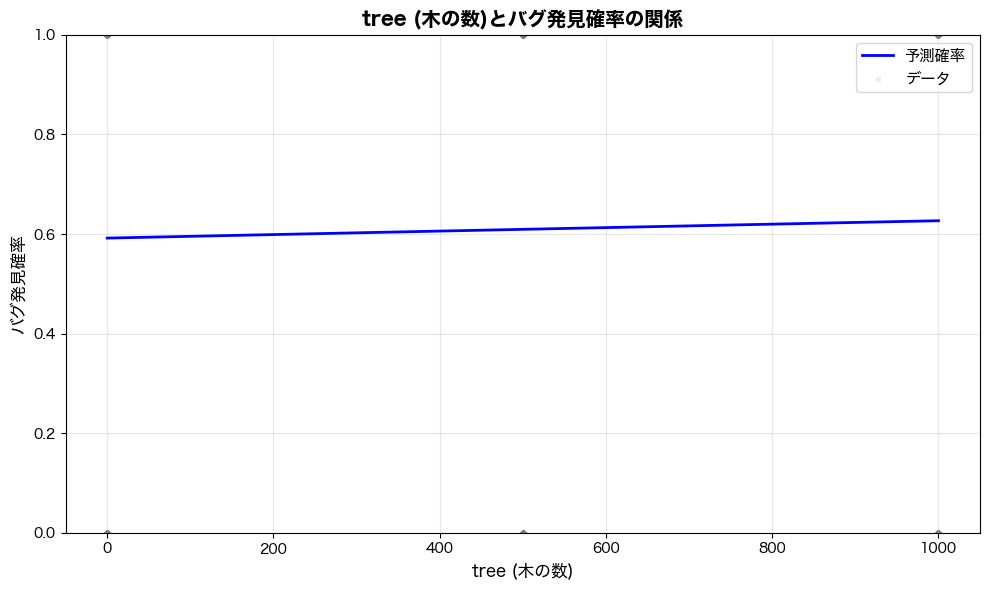

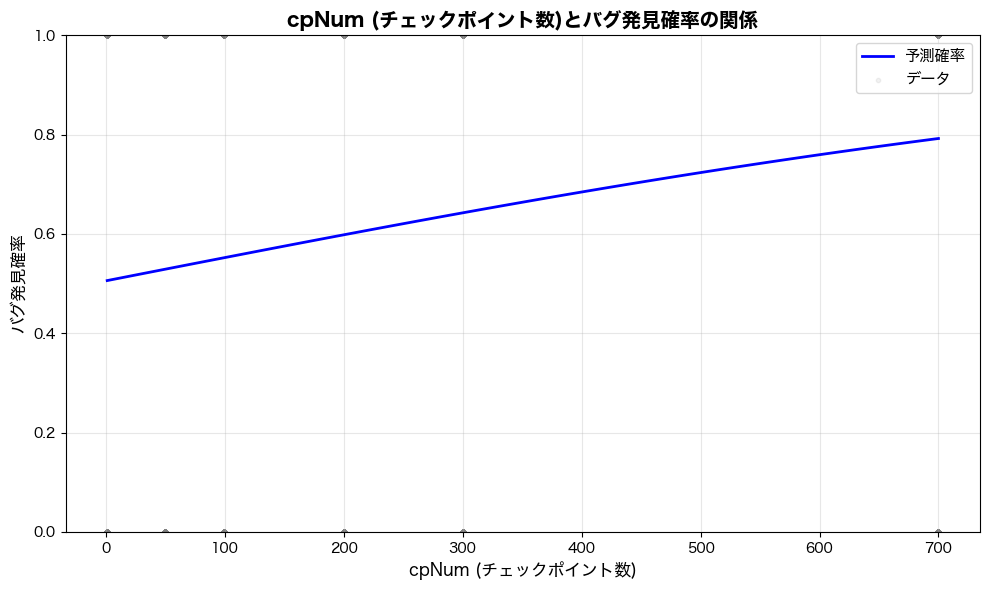

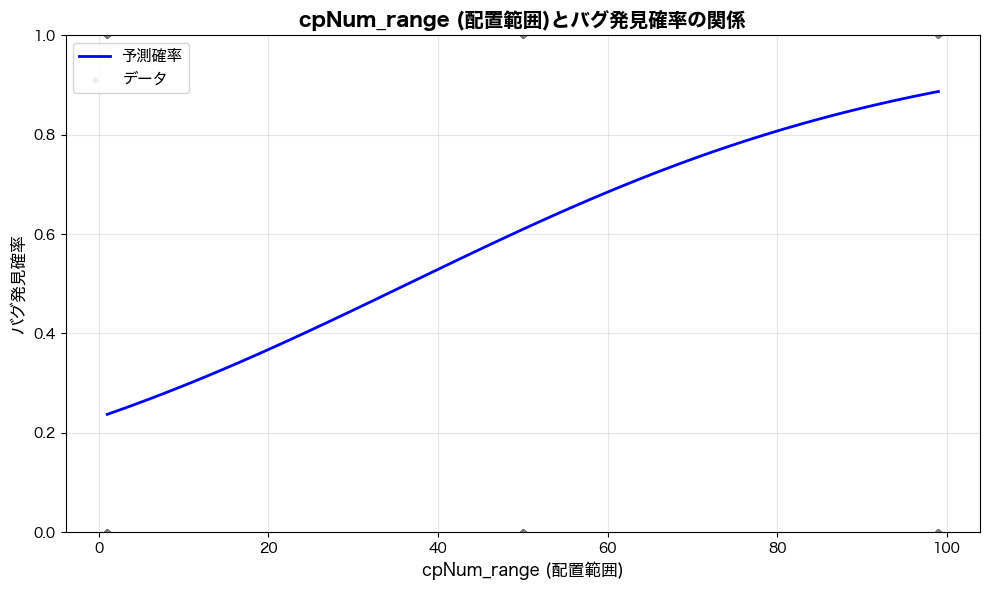

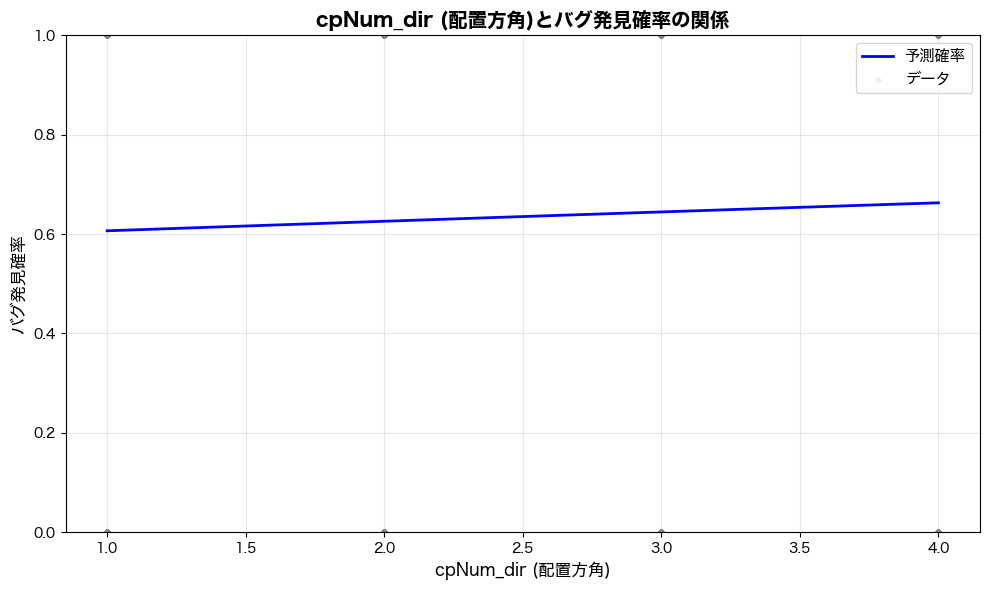

In [577]:

# sklearnを使用したロジスティック回帰（予測精度の評価のため）
# 説明変数と目的変数の準備
X = df[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y = df['bug_detected']

# データを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 標準化（オプション：必要に応じて）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ロジスティック回帰モデルの学習
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# 予測
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# 評価指標
print("="*70)
print("【バグ発見の有無】分類結果（sklearn）")
print("="*70)
print("\n分類レポート:")
print(classification_report(y_test, y_pred, target_names=['バグなし', 'バグあり']))

# ロジスティック回帰曲線の可視化（各説明変数ごとに別々の画像）
print("\n" + "="*70)
print("ロジスティック回帰曲線（バグ発見の有無）")
print("="*70)

# 各変数の平均値
mean_tree = df['tree'].mean()
mean_cpNum = df['cpNum'].mean()
mean_cpNum_range = df['cpNum_range'].mean()
mean_cpNum_dir = df['cpNum_dir'].mean()

variables = ['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']
var_labels = ['tree (木の数)', 'cpNum (チェックポイント数)', 'cpNum_range (配置範囲)', 'cpNum_dir (配置方角)']
mean_values = [mean_tree, mean_cpNum, mean_cpNum_range, mean_cpNum_dir]

for var, label, mean_val in zip(variables, var_labels, mean_values):
    # 変数の範囲を取得
    var_min = df[var].min()
    var_max = df[var].max()
    var_range = np.linspace(var_min, var_max, 100)
    
    # 予測確率を計算
    predictions = []
    for val in var_range:
        # 他の変数は平均値に固定
        X_pred = pd.DataFrame({
            'tree': [mean_tree if var != 'tree' else val],
            'cpNum': [mean_cpNum if var != 'cpNum' else val],
            'cpNum_range': [mean_cpNum_range if var != 'cpNum_range' else val],
            'cpNum_dir': [mean_cpNum_dir if var != 'cpNum_dir' else val]
        })
        pred_prob = logit_result.predict(X_pred)[0]
        predictions.append(pred_prob)
    
    # 個別のグラフを描画
    plt.figure(figsize=(10, 6))
    plt.plot(var_range, predictions, 'b-', linewidth=2, label='予測確率')
    plt.scatter(df[var], df['bug_detected'], alpha=0.1, s=10, c='gray', label='データ')
    plt.xlabel(label, fontsize=12)
    plt.ylabel('バグ発見確率', fontsize=12)
    plt.title(f'{label}とバグ発見確率の関係', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.show()


In [578]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

# ベースラインモデルの予測を作成
# y_testのサイズに合わせて、すべて1（バグあり）またはすべて0（バグなし）の配列を作成
y_pred_always_bug = np.ones(len(y_test))
y_pred_always_no_bug = np.zeros(len(y_test))

print("="*70)
print("ベースラインモデルとの比較（バグ発見の有無）")
print("="*70)

# 1. ロジスティック回帰モデル（比較用）
print("【ロジスティック回帰モデル】")
print(classification_report(y_test, y_pred, target_names=['バグなし', 'バグあり']))
print("単一指標 (陽性=1):")
print(f"Precision: {precision_score(y_test, y_pred, pos_label=1):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred, pos_label=1):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred, pos_label=1):.4f}")
print("-" * 70)

# 2. 常にバグありと判定するモデル
print("【常にバグありと判定するモデル】")
# zero_division=0を指定して警告を抑制
print(classification_report(y_test, y_pred_always_bug, target_names=['バグなし', 'バグあり'], zero_division=0))
print("単一指標 (陽性=1):")
print(f"Precision: {precision_score(y_test, y_pred_always_bug, pos_label=1, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_always_bug, pos_label=1, zero_division=0):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred_always_bug, pos_label=1, zero_division=0):.4f}")
print("-" * 70)

# 3. 常にバグなしと判定するモデル
print("【常にバグなしと判定するモデル】")
print(classification_report(y_test, y_pred_always_no_bug, target_names=['バグなし', 'バグあり'], zero_division=0))
print("単一指標 (陽性=1):")
print(f"Precision: {precision_score(y_test, y_pred_always_no_bug, pos_label=1, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_always_no_bug, pos_label=1, zero_division=0):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred_always_no_bug, pos_label=1, zero_division=0):.4f}")
print("-" * 70)

precision = precision_score(y_test, y_pred, pos_label=1)
recall = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)

# 係数の表示
print("\n係数 (標準化後):")
for name, coef in zip(X.columns, lr_model.coef_[0]):
    print(f"{name}: {coef:.4f}")
print(f"切片: {lr_model.intercept_[0]:.4f}")

ベースラインモデルとの比較（バグ発見の有無）
【ロジスティック回帰モデル】
              precision    recall  f1-score   support

        バグなし       0.81      0.73      0.77       915
        バグあり       0.81      0.88      0.84      1245

    accuracy                           0.81      2160
   macro avg       0.81      0.80      0.81      2160
weighted avg       0.81      0.81      0.81      2160

単一指標 (陽性=1):
Precision: 0.8142
Recall   : 0.8763
F1-score : 0.8441
----------------------------------------------------------------------
【常にバグありと判定するモデル】
              precision    recall  f1-score   support

        バグなし       0.00      0.00      0.00       915
        バグあり       0.58      1.00      0.73      1245

    accuracy                           0.58      2160
   macro avg       0.29      0.50      0.37      2160
weighted avg       0.33      0.58      0.42      2160

単一指標 (陽性=1):
Precision: 0.5764
Recall   : 1.0000
F1-score : 0.7313
----------------------------------------------------------------------
【常にバグなしと判定するモデル

## 1-2. バグ発見の有無：変数増減法による全変数組み合わせのF値計算

変数増減法を用いて、全ての変数の組み合わせでロジスティック回帰モデルを構築し、各組み合わせのF1スコアを計算します。
これにより、どの変数の組み合わせが最も予測性能が高いかを評価できます。

In [579]:
# 変数増減法：全変数組み合わせでF値を計算
from itertools import combinations
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 説明変数と目的変数の準備（既に定義されているX, yを使用）
# 注意: このセルを実行する前に、X, y, X_train, X_test, y_train, y_testが定義されている必要があります
# これらの変数は、バグ発見の有無の分析セクションで既に定義されています

# 全ての変数の組み合わせを生成（空集合を含む）
variables = ['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']
all_combinations = []

# 0個から4個までの全ての組み合わせを生成
for r in range(len(variables) + 1):
    for combo in combinations(variables, r):
        all_combinations.append(list(combo))

print("="*70)
print("【バグ発見の有無】変数増減法による全変数組み合わせのF値計算")
print("="*70)
print(f"\n総組み合わせ数: {len(all_combinations)}通り\n")

# 結果を格納するリスト
results = []

# 各組み合わせでモデルを構築し、F値を計算
for i, combo in enumerate(all_combinations, 1):
    if len(combo) == 0:
        # 空集合の場合は、常に多数派クラスを予測するモデル
        # バグありが多数派なので、常に1を予測
        y_pred_combo = np.ones(len(y_test))
        f1 = f1_score(y_test, y_pred_combo, pos_label=1, zero_division=0)
        precision = precision_score(y_test, y_pred_combo, pos_label=1, zero_division=0)
        recall = recall_score(y_test, y_pred_combo, pos_label=1, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred_combo)
        combo_str = "（定数モデル：常にバグあり）"
    else:
        # 選択された変数でモデルを構築
        X_train_combo = X_train[combo]
        X_test_combo = X_test[combo]
        
        # 標準化
        scaler_combo = StandardScaler()
        X_train_combo_scaled = scaler_combo.fit_transform(X_train_combo)
        X_test_combo_scaled = scaler_combo.transform(X_test_combo)
        
        # ロジスティック回帰モデルの学習
        lr_model_combo = LogisticRegression(random_state=42, max_iter=1000)
        lr_model_combo.fit(X_train_combo_scaled, y_train)
        
        # 予測
        y_pred_combo = lr_model_combo.predict(X_test_combo_scaled)
        
        # 評価指標
        f1 = f1_score(y_test, y_pred_combo, pos_label=1)
        precision = precision_score(y_test, y_pred_combo, pos_label=1)
        recall = recall_score(y_test, y_pred_combo, pos_label=1)
        accuracy = accuracy_score(y_test, y_pred_combo)
        combo_str = ", ".join(combo)
    
    # 結果を保存
    results.append({
        '組み合わせ番号': i,
        '変数の組み合わせ': combo_str,
        '変数の数': len(combo),
        'F1スコア': f1,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy
    })
    
    # 進捗表示（10件ごと、または重要な組み合わせ）
    if i % 5 == 0 or len(combo) <= 1 or len(combo) == len(variables):
        print(f"{i:2d}. 変数: {combo_str:40s} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | Accuracy: {accuracy:.4f}")

# 結果をDataFrameに変換
results_df = pd.DataFrame(results)

# F1スコアでソート
results_df_sorted = results_df.sort_values('F1スコア', ascending=False)

print("\n" + "="*70)
print("【結果サマリー】F1スコア順（上位10件）")
print("="*70)
print(results_df_sorted.head(10).to_string(index=False))

print("\n" + "="*70)
print("【結果サマリー】変数の数ごとの最高F1スコア")
print("="*70)
for num_vars in range(len(variables) + 1):
    subset = results_df[results_df['変数の数'] == num_vars]
    if len(subset) > 0:
        best = subset.loc[subset['F1スコア'].idxmax()]
        print(f"\n変数の数: {num_vars}")
        print(f"  最高F1スコア: {best['F1スコア']:.4f}")
        print(f"  変数の組み合わせ: {best['変数の組み合わせ']}")
        print(f"  Precision: {best['Precision']:.4f}, Recall: {best['Recall']:.4f}, Accuracy: {best['Accuracy']:.4f}")

# 全ての結果を表示
print("\n" + "="*70)
print("【全結果】F1スコア順")
print("="*70)
print(results_df_sorted.to_string(index=False))

# 結果をCSVファイルに保存（オプション）
# results_df_sorted.to_csv('variable_selection_results.csv', index=False, encoding='utf-8-sig')
# print("\n結果を 'variable_selection_results.csv' に保存しました。")

【バグ発見の有無】変数増減法による全変数組み合わせのF値計算

総組み合わせ数: 16通り

 1. 変数: （定数モデル：常にバグあり）                           | F1: 0.7313 | Precision: 0.5764 | Recall: 1.0000 | Accuracy: 0.5764
 2. 変数: tree                                     | F1: 0.7313 | Precision: 0.5764 | Recall: 1.0000 | Accuracy: 0.5764
 3. 変数: cpNum                                    | F1: 0.7313 | Precision: 0.5764 | Recall: 1.0000 | Accuracy: 0.5764
 4. 変数: cpNum_range                              | F1: 0.8328 | Precision: 0.7825 | Recall: 0.8900 | Accuracy: 0.7940
 5. 変数: cpNum_dir                                | F1: 0.7313 | Precision: 0.5764 | Recall: 1.0000 | Accuracy: 0.5764
10. 変数: cpNum, cpNum_dir                         | F1: 0.7313 | Precision: 0.5764 | Recall: 1.0000 | Accuracy: 0.5764
15. 変数: cpNum, cpNum_range, cpNum_dir            | F1: 0.8468 | Precision: 0.8286 | Recall: 0.8659 | Accuracy: 0.8194
16. 変数: tree, cpNum, cpNum_range, cpNum_dir      | F1: 0.8441 | Precision: 0.8142 | Recall: 0.8763 | Accuracy: 0.8134

【結果サマリー】

## 2. タイムアウトの有無（二値分類）のロジスティック回帰分析

パラメータ（tree, cpNum, cpNum_range, cpNum_dir）からタイムアウトの確率を予測します。


In [580]:
# 2. タイムアウトの有無（二値分類）のロジスティック回帰分析

# statsmodels.formula.apiを使用したロジスティック回帰（Rスタイルの式を使用）
logit_model_timeout = smf.logit('timeout ~ tree + cpNum + cpNum_range + cpNum_dir', data=df)
logit_result_timeout = logit_model_timeout.fit(disp=0)

print("="*70)
print("【タイムアウトの有無】ロジスティック回帰分析結果（statsmodels.formula.api）")
print("="*70)
print(logit_result_timeout.summary())

# 係数の95%信頼区間を取得
conf_int_timeout = logit_result_timeout.conf_int(alpha=0.05)
conf_int_timeout.columns = ['95% CI Lower', '95% CI Upper']

# オッズ比とその95%信頼区間を計算
print("\n" + "="*70)
print("オッズ比（Odds Ratio）と95%信頼区間")
print("="*70)
odds_ratios_timeout = np.exp(logit_result_timeout.params)
odds_ci_lower_timeout = np.exp(conf_int_timeout['95% CI Lower'])
odds_ci_upper_timeout = np.exp(conf_int_timeout['95% CI Upper'])

for var in logit_result_timeout.params.index:
    odds_ratio = odds_ratios_timeout[var]
    ci_lower = odds_ci_lower_timeout[var]
    ci_upper = odds_ci_upper_timeout[var]
    
    print(f"\n  {var}:")
    print(f"    オッズ比: {odds_ratio:.4f}")
    print(f"    95%信頼区間: [{ci_lower:.4f}, {ci_upper:.4f}]")
    
    if odds_ratio > 1:
        print(f"    → {var}が1単位増加すると、タイムアウトのオッズが{(odds_ratio-1)*100:.2f}%増加")
    elif odds_ratio < 1:
        print(f"    → {var}が1単位増加すると、タイムアウトのオッズが{(1-odds_ratio)*100:.2f}%減少")

# ロジスティック回帰式の出力
print("\n" + "="*70)
print("【タイムアウトの有無】ロジスティック回帰式")
print("="*70)

# 係数を取得
intercept_timeout = logit_result_timeout.params['Intercept']
coef_tree_timeout = logit_result_timeout.params['tree']
coef_cpNum_timeout = logit_result_timeout.params['cpNum']
coef_cpNum_range_timeout = logit_result_timeout.params['cpNum_range']
coef_cpNum_dir_timeout = logit_result_timeout.params['cpNum_dir']

print("\n【ロジット関数（式）】")
formula_parts_timeout = [f"{intercept_timeout:.6f}"]
if coef_tree_timeout != 0:
    sign = " + " if coef_tree_timeout >= 0 else " - "
    abs_coef = abs(coef_tree_timeout)
    formula_parts_timeout.append(f"{sign}{abs_coef:.6f} × tree")
if coef_cpNum_timeout != 0:
    sign = " + " if coef_cpNum_timeout >= 0 else " - "
    abs_coef = abs(coef_cpNum_timeout)
    formula_parts_timeout.append(f"{sign}{abs_coef:.6f} × cpNum")
if coef_cpNum_range_timeout != 0:
    sign = " + " if coef_cpNum_range_timeout >= 0 else " - "
    abs_coef = abs(coef_cpNum_range_timeout)
    formula_parts_timeout.append(f"{sign}{abs_coef:.6f} × cpNum_range")
if coef_cpNum_dir_timeout != 0:
    sign = " + " if coef_cpNum_dir_timeout >= 0 else " - "
    abs_coef = abs(coef_cpNum_dir_timeout)
    formula_parts_timeout.append(f"{sign}{abs_coef:.6f} × cpNum_dir")

formula_timeout = "".join(formula_parts_timeout)
print(f"logit = {formula_timeout}")

print("\n【展開形式】")
print(f"logit = {intercept_timeout:.6f}", end="")
if coef_tree_timeout != 0:
    sign = " + " if coef_tree_timeout >= 0 else " - "
    abs_coef = abs(coef_tree_timeout)
    print(f"{sign}{abs_coef:.6f} × tree", end="")
if coef_cpNum_timeout != 0:
    sign = " + " if coef_cpNum_timeout >= 0 else " - "
    abs_coef = abs(coef_cpNum_timeout)
    print(f"{sign}{abs_coef:.6f} × cpNum", end="")
if coef_cpNum_range_timeout != 0:
    sign = " + " if coef_cpNum_range_timeout >= 0 else " - "
    abs_coef = abs(coef_cpNum_range_timeout)
    print(f"{sign}{abs_coef:.6f} × cpNum_range", end="")
if coef_cpNum_dir_timeout != 0:
    sign = " + " if coef_cpNum_dir_timeout >= 0 else " - "
    abs_coef = abs(coef_cpNum_dir_timeout)
    print(f"{sign}{abs_coef:.6f} × cpNum_dir", end="")
print()

print("\n【確率の計算式（ロジスティック関数）】")
print("""
タイムアウトの確率は、ロジスティック関数で計算されます：

P(タイムアウト) = 1 / (1 + exp(-logit))

タイムアウトなしの確率は：

P(タイムアウトなし) = 1 - P(タイムアウト) = exp(-logit) / (1 + exp(-logit))

予測されるクラスは、P(タイムアウト) > 0.5 なら「タイムアウト」、そうでなければ「タイムアウトなし」です。
""")

# 検証: 実際に計算して確認
print("\n" + "="*70)
print("【検証: 実際の計算例】")
print("="*70)

test_params_timeout = {
    'tree': 500,
    'cpNum': 200,
    'cpNum_range': 50,
    'cpNum_dir': 2
}

print(f"\nパラメータ: {test_params_timeout}")

# ロジットを計算
logit_timeout = intercept_timeout
logit_timeout += coef_tree_timeout * test_params_timeout['tree']
logit_timeout += coef_cpNum_timeout * test_params_timeout['cpNum']
logit_timeout += coef_cpNum_range_timeout * test_params_timeout['cpNum_range']
logit_timeout += coef_cpNum_dir_timeout * test_params_timeout['cpNum_dir']

print(f"\n【ロジット計算】")
print(f"logit = {intercept_timeout:.6f}", end="")
if coef_tree_timeout != 0:
    sign = " + " if coef_tree_timeout >= 0 else " - "
    abs_coef = abs(coef_tree_timeout)
    print(f"{sign}{abs_coef:.6f} × {test_params_timeout['tree']}", end="")
if coef_cpNum_timeout != 0:
    sign = " + " if coef_cpNum_timeout >= 0 else " - "
    abs_coef = abs(coef_cpNum_timeout)
    print(f"{sign}{abs_coef:.6f} × {test_params_timeout['cpNum']}", end="")
if coef_cpNum_range_timeout != 0:
    sign = " + " if coef_cpNum_range_timeout >= 0 else " - "
    abs_coef = abs(coef_cpNum_range_timeout)
    print(f"{sign}{abs_coef:.6f} × {test_params_timeout['cpNum_range']}", end="")
if coef_cpNum_dir_timeout != 0:
    sign = " + " if coef_cpNum_dir_timeout >= 0 else " - "
    abs_coef = abs(coef_cpNum_dir_timeout)
    print(f"{sign}{abs_coef:.6f} × {test_params_timeout['cpNum_dir']}", end="")
print()

# 計算結果を表示
term1_timeout = intercept_timeout
term2_timeout = coef_tree_timeout * test_params_timeout['tree']
term3_timeout = coef_cpNum_timeout * test_params_timeout['cpNum']
term4_timeout = coef_cpNum_range_timeout * test_params_timeout['cpNum_range']
term5_timeout = coef_cpNum_dir_timeout * test_params_timeout['cpNum_dir']
print(f"     = {term1_timeout:.6f} + {term2_timeout:.6f} + {term3_timeout:.6f} + {term4_timeout:.6f} + {term5_timeout:.6f}")
print(f"     = {logit_timeout:.6f}")

# 確率を計算
prob_timeout = 1 / (1 + np.exp(-logit_timeout))
prob_no_timeout = 1 - prob_timeout

print("\n計算された確率:")
print(f"  タイムアウトなし: {prob_no_timeout:.4f} ({prob_no_timeout*100:.2f}%)")
print(f"  タイムアウト: {prob_timeout:.4f} ({prob_timeout*100:.2f}%)")

# モデルでの予測と比較
X_test_manual_timeout = pd.DataFrame([test_params_timeout])
pred_proba_manual_timeout = logit_result_timeout.predict(X_test_manual_timeout)

print("\nモデルでの予測確率（検証用）:")
print(f"  タイムアウトなし: {1-pred_proba_manual_timeout[0]:.4f} ({(1-pred_proba_manual_timeout[0])*100:.2f}%)")
print(f"  タイムアウト: {pred_proba_manual_timeout[0]:.4f} ({pred_proba_manual_timeout[0]*100:.2f}%)")

print("\n（注: 計算結果とモデルの予測が一致することを確認）")


【タイムアウトの有無】ロジスティック回帰分析結果（statsmodels.formula.api）
                           Logit Regression Results                           
Dep. Variable:                timeout   No. Observations:                10800
Model:                          Logit   Df Residuals:                    10795
Method:                           MLE   Df Model:                            4
Date:                Thu, 11 Dec 2025   Pseudo R-squ.:                 0.04870
Time:                        13:17:16   Log-Likelihood:                -2268.6
converged:                       True   LL-Null:                       -2384.7
Covariance Type:            nonrobust   LLR p-value:                 4.243e-49
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.6057      0.138    -26.186      0.000      -3.876      -3.336
tree           -0.0005      0.000     -4.879      0.000      -0.001      -0.00

【タイムアウトの有無】分類結果（sklearn）

分類レポート:
              precision    recall  f1-score   support

    タイムアウトなし       0.94      1.00      0.97      2035
    タイムアウトあり       0.00      0.00      0.00       125

    accuracy                           0.94      2160
   macro avg       0.47      0.50      0.49      2160
weighted avg       0.89      0.94      0.91      2160


混同行列:
[[2035    0]
 [ 125    0]]


/Users/yamaguchiyusei/programming/localfuzz_analysis/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/yamaguchiyusei/programming/localfuzz_analysis/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/yamaguchiyusei/programming/localfuzz_analysis/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter

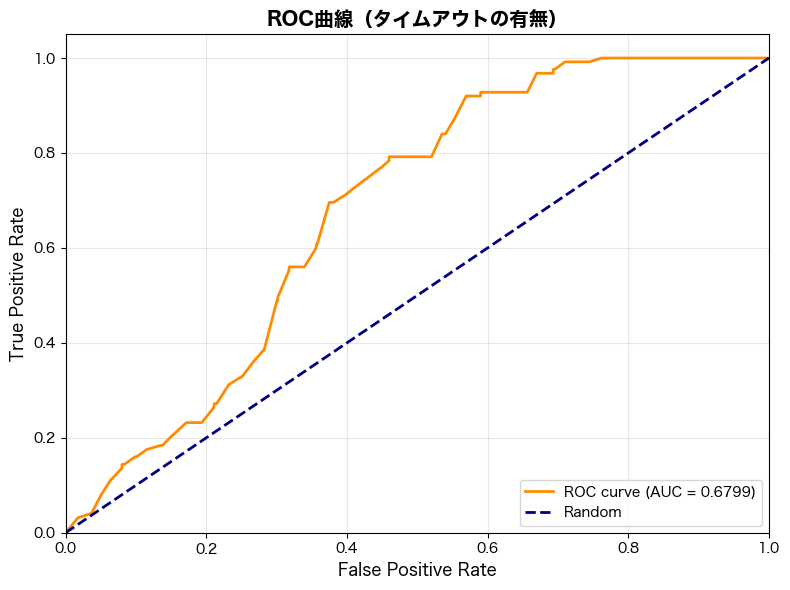


AUC: 0.6799

ロジスティック回帰曲線（タイムアウトの有無）


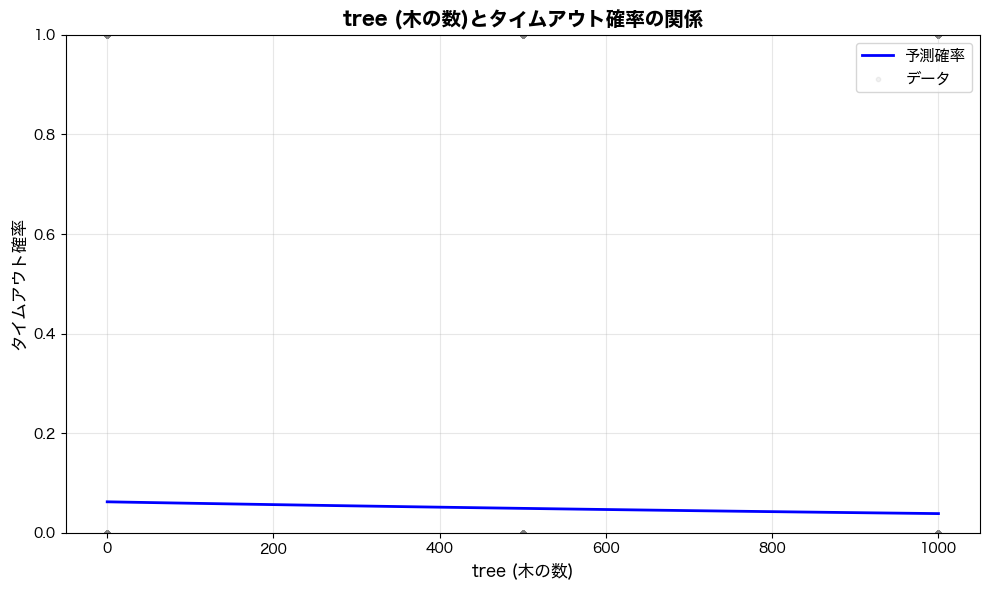

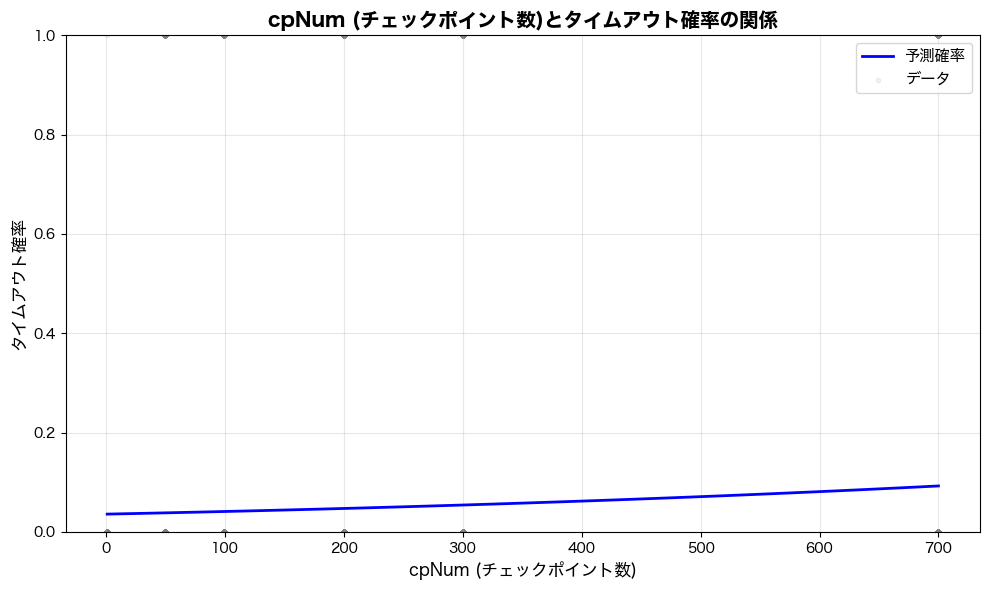

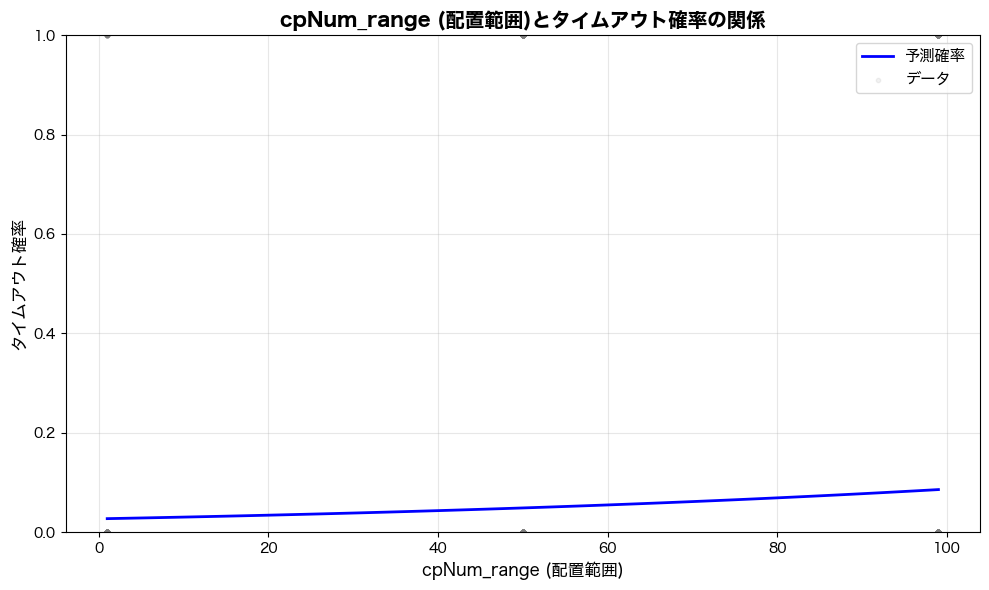

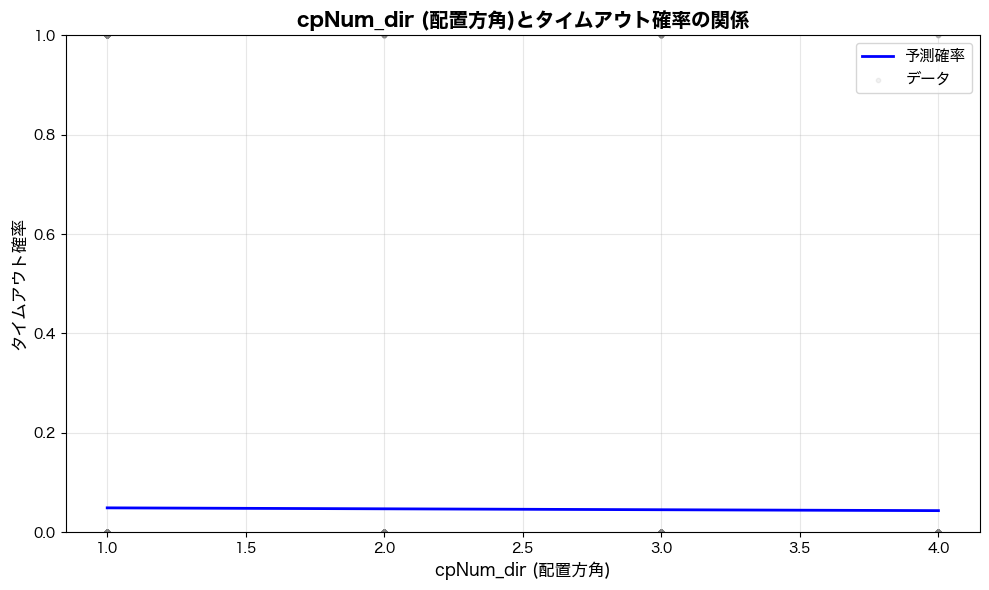

In [581]:
# sklearnを使用したロジスティック回帰（予測精度の評価のため）
# 説明変数と目的変数の準備
X = df[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y = df['timeout']

# データを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ロジスティック回帰モデルの学習
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# 予測
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

# 評価指標
print("="*70)
print("【タイムアウトの有無】分類結果（sklearn）")
print("="*70)
print("\n分類レポート:")
print(classification_report(y_test, y_pred, target_names=['タイムアウトなし', 'タイムアウトあり']))

print("\n混同行列:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# ROC曲線とAUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC曲線（タイムアウトの有無）', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAUC: {roc_auc:.4f}")

# ロジスティック回帰曲線の可視化（各説明変数ごとに別々の画像）
print("\n" + "="*70)
print("ロジスティック回帰曲線（タイムアウトの有無）")
print("="*70)

# 各変数の平均値
mean_tree = df['tree'].mean()
mean_cpNum = df['cpNum'].mean()
mean_cpNum_range = df['cpNum_range'].mean()
mean_cpNum_dir = df['cpNum_dir'].mean()

variables = ['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']
var_labels = ['tree (木の数)', 'cpNum (チェックポイント数)', 'cpNum_range (配置範囲)', 'cpNum_dir (配置方角)']
mean_values = [mean_tree, mean_cpNum, mean_cpNum_range, mean_cpNum_dir]

for var, label, mean_val in zip(variables, var_labels, mean_values):
    # 変数の範囲を取得
    var_min = df[var].min()
    var_max = df[var].max()
    var_range = np.linspace(var_min, var_max, 100)
    
    # 予測確率を計算
    predictions = []
    for val in var_range:
        # 他の変数は平均値に固定
        X_pred = pd.DataFrame({
            'tree': [mean_tree if var != 'tree' else val],
            'cpNum': [mean_cpNum if var != 'cpNum' else val],
            'cpNum_range': [mean_cpNum_range if var != 'cpNum_range' else val],
            'cpNum_dir': [mean_cpNum_dir if var != 'cpNum_dir' else val]
        })
        pred_prob = logit_result_timeout.predict(X_pred)[0]
        predictions.append(pred_prob)
    
    # 個別のグラフを描画
    plt.figure(figsize=(10, 6))
    plt.plot(var_range, predictions, 'b-', linewidth=2, label='予測確率')
    plt.scatter(df[var], df['timeout'], alpha=0.1, s=10, c='gray', label='データ')
    plt.xlabel(label, fontsize=12)
    plt.ylabel('タイムアウト確率', fontsize=12)
    plt.title(f'{label}とタイムアウト確率の関係', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.show()


## 2-1. タイムアウトの有無：適合度評価指標

二値分類モデルの適合度を評価します。


In [582]:
# 2-1. タイムアウトの有無：適合度評価指標

# タイムアウトのモデルはCell 9で既に作成済み（logit_result_timeout）なので、それをそのまま使用
# もしCell 9を実行していない場合は、以下のコメントを外してモデルを作成してください
# logit_model_timeout = smf.logit('timeout ~ tree + cpNum + cpNum_range + cpNum_dir', data=df)
# logit_result_timeout = logit_model_timeout.fit(disp=0)

print("="*70)
print("【タイムアウトの有無】適合度評価指標")
print("="*70)

# ===== 1. Pseudo R-squared (McFadden) =====
print("\n" + "="*70)
print("【1. Pseudo R-squared (McFadden)】")
print("="*70)
print(f"Pseudo R-squared: {logit_result_timeout.prsquared:.4f}")
print(f"  → 0に近いほど適合度が低く、1に近いほど適合度が高い")
print(f"  → 0.2-0.4程度で実用的なモデルとされる")
print(f"  → 現在の値は{'良好' if logit_result_timeout.prsquared > 0.2 else 'やや低い'}")

# ===== 2. AIC/BIC =====
print("\n" + "="*70)
print("【2. AIC/BIC】")
print("="*70)
print(f"AIC (Akaike Information Criterion): {logit_result_timeout.aic:.2f}")
print(f"BIC (Bayesian Information Criterion): {logit_result_timeout.bic:.2f}")
print(f"  → 小さいほど良いモデル（モデル比較に使用）")

# ===== 3. 対数尤度と尤度比検定 =====
print("\n" + "="*70)
print("【3. 対数尤度と尤度比検定】")
print("="*70)
print(f"対数尤度 (Log-Likelihood): {logit_result_timeout.llf:.2f}")
print(f"Null対数尤度 (LL-Null): {logit_result_timeout.llnull:.2f}")
print(f"尤度比 (Likelihood Ratio): {logit_result_timeout.llr:.2f}")
print(f"尤度比検定 p-value (LLR p-value): {logit_result_timeout.llr_pvalue:.2e}")
print(f"  → LLR p-value < 0.05 なら、モデルはNullモデルより有意に優れている")
print(f"  → 現在のモデルは{'有意に優れている' if logit_result_timeout.llr_pvalue < 0.05 else '有意に優れていない'}")

# 尤度比の解釈
improvement_ratio_timeout = (logit_result_timeout.llf - logit_result_timeout.llnull) / abs(logit_result_timeout.llnull)
print(f"\n尤度改善率: {improvement_ratio_timeout:.4f}")
print(f"  → Nullモデルと比較して、対数尤度が{improvement_ratio_timeout*100:.2f}%改善")


【タイムアウトの有無】適合度評価指標

【1. Pseudo R-squared (McFadden)】
Pseudo R-squared: 0.0487
  → 0に近いほど適合度が低く、1に近いほど適合度が高い
  → 0.2-0.4程度で実用的なモデルとされる
  → 現在の値はやや低い

【2. AIC/BIC】
AIC (Akaike Information Criterion): 4547.18
BIC (Bayesian Information Criterion): 4583.61
  → 小さいほど良いモデル（モデル比較に使用）

【3. 対数尤度と尤度比検定】
対数尤度 (Log-Likelihood): -2268.59
Null対数尤度 (LL-Null): -2384.73
尤度比 (Likelihood Ratio): 232.29
尤度比検定 p-value (LLR p-value): 4.24e-49
  → LLR p-value < 0.05 なら、モデルはNullモデルより有意に優れている
  → 現在のモデルは有意に優れている

尤度改善率: 0.0487
  → Nullモデルと比較して、対数尤度が4.87%改善


## 3. 実行結果の分類（多クラス分類）のロジスティック回帰分析

パラメータ（tree, cpNum, cpNum_range, cpNum_dir）から実行結果（Null、バグ発見、タイムアウト）を予測します。


【実行結果の分類】多クラスロジスティック回帰分析結果

分類レポート:
              precision    recall  f1-score   support

        Null       0.74      0.92      0.82      1245
        バグ発見       0.84      0.65      0.73       790
      タイムアウト       0.00      0.00      0.00       125

    accuracy                           0.77      2160
   macro avg       0.53      0.52      0.52      2160
weighted avg       0.73      0.77      0.74      2160


混同行列:
[[ 511  279    0]
 [ 100 1145    0]
 [   0  125    0]]


/Users/yamaguchiyusei/programming/localfuzz_analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/yamaguchiyusei/programming/localfuzz_analysis/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/yamaguchiyusei/programming/localfuzz_analysis/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_p

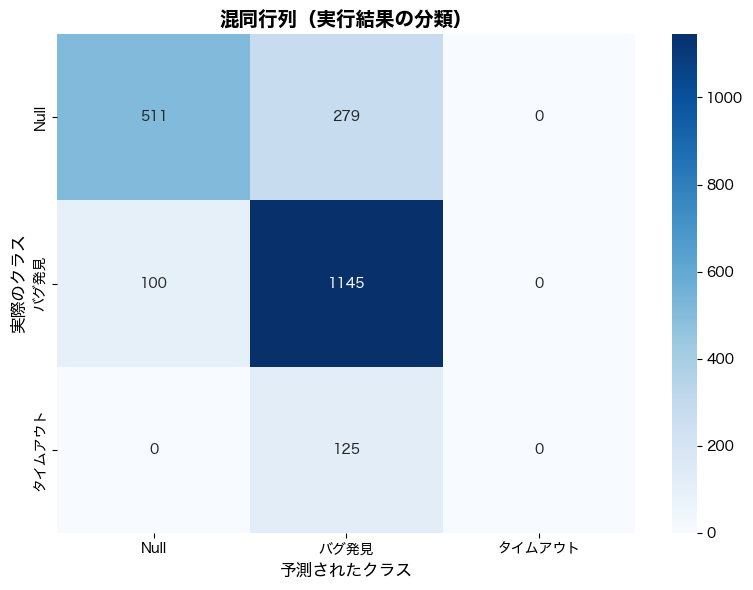

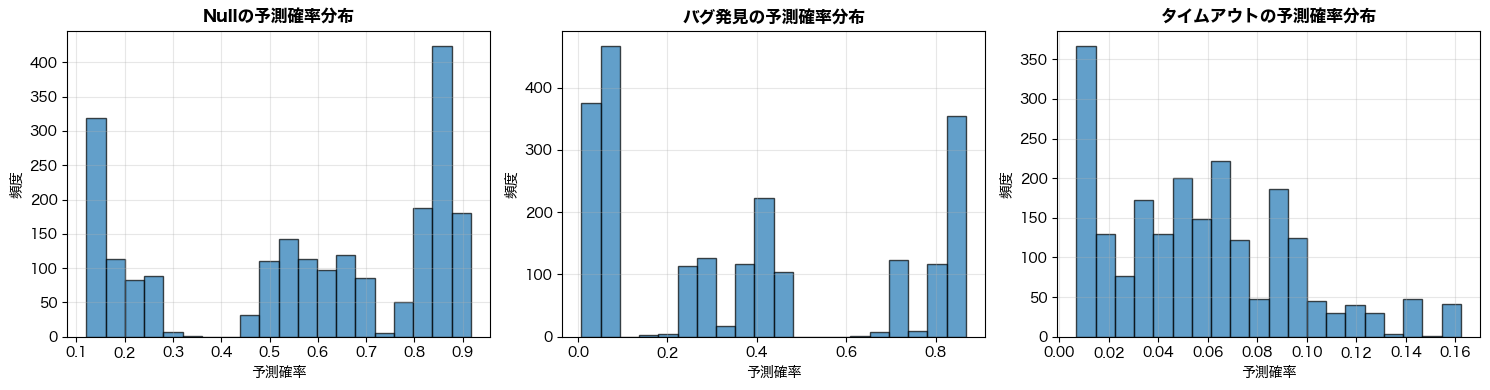

In [583]:
# 3. 実行結果の分類（多クラス分類）のロジスティック回帰分析

# 説明変数と目的変数の準備
X = df[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y = df['result_category']

# データを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 多クラスロジスティック回帰モデルの学習
lr_model = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='lbfgs')
lr_model.fit(X_train_scaled, y_train)

# 予測
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)

# 評価指標
print("="*70)
print("【実行結果の分類】多クラスロジスティック回帰分析結果")
print("="*70)
print("\n分類レポート:")
print(classification_report(y_test, y_pred, target_names=['Null', 'バグ発見', 'タイムアウト']))

print("\n混同行列:")
cm = confusion_matrix(y_test, y_pred, labels=['normal', 'bug', 'timeout'])
print(cm)

# 混同行列の可視化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Null', 'バグ発見', 'タイムアウト'],
            yticklabels=['Null', 'バグ発見', 'タイムアウト'])
plt.title('混同行列（実行結果の分類）', fontsize=14, fontweight='bold')
plt.ylabel('実際のクラス', fontsize=12)
plt.xlabel('予測されたクラス', fontsize=12)
plt.tight_layout()
plt.show()

# 各クラスの予測確率の分布を可視化
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
classes = ['normal', 'bug', 'timeout']
class_names = ['Null', 'バグ発見', 'タイムアウト']

for idx, (cls, cls_name) in enumerate(zip(classes, class_names)):
    proba = y_pred_proba[:, idx]
    axes[idx].hist(proba, bins=20, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'{cls_name}の予測確率分布', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('予測確率', fontsize=10)
    axes[idx].set_ylabel('頻度', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



ロジスティック回帰曲線（実行結果の分類）


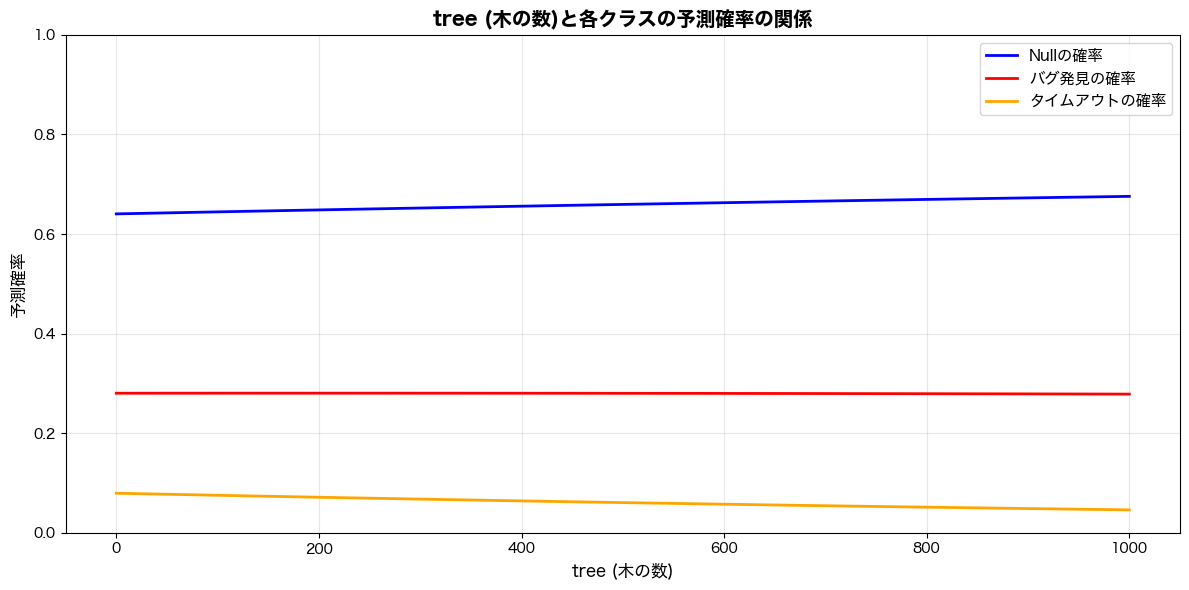

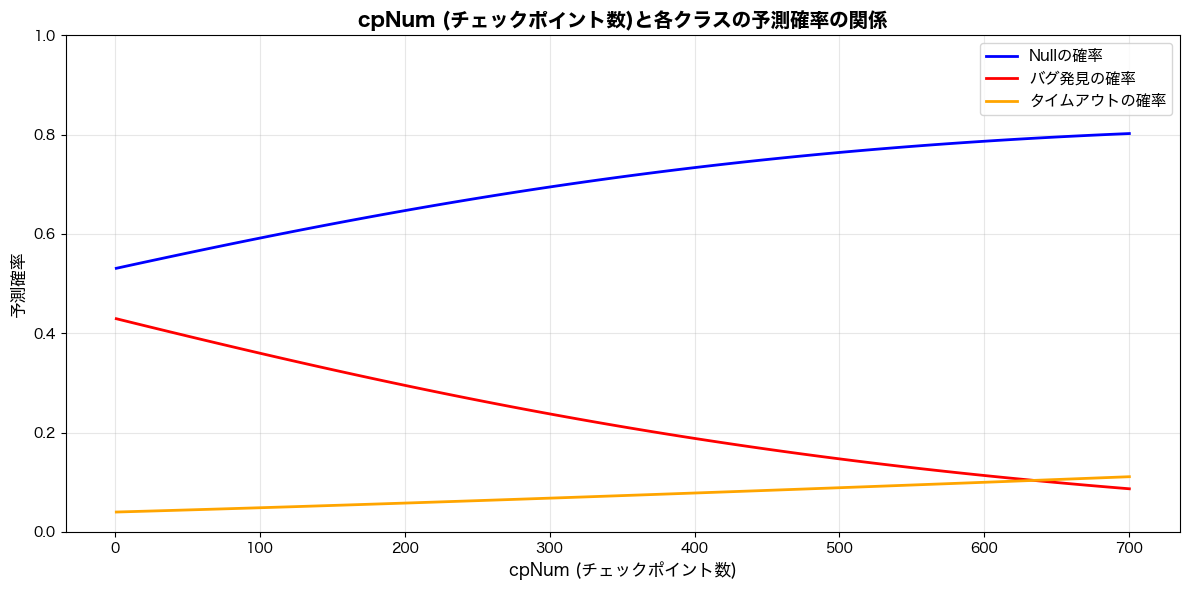

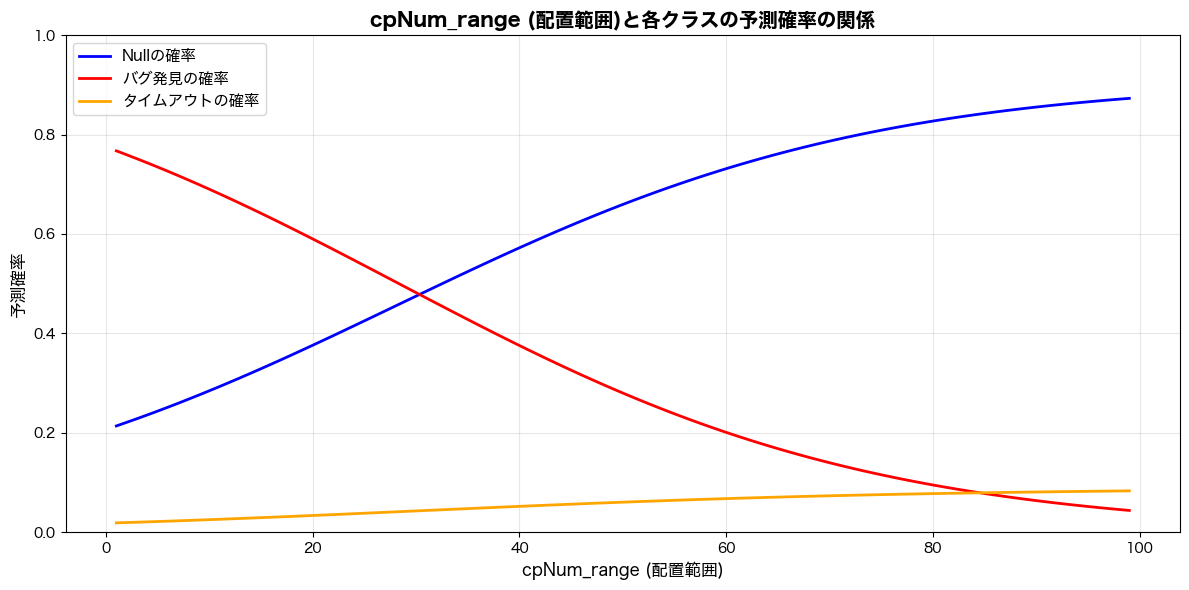

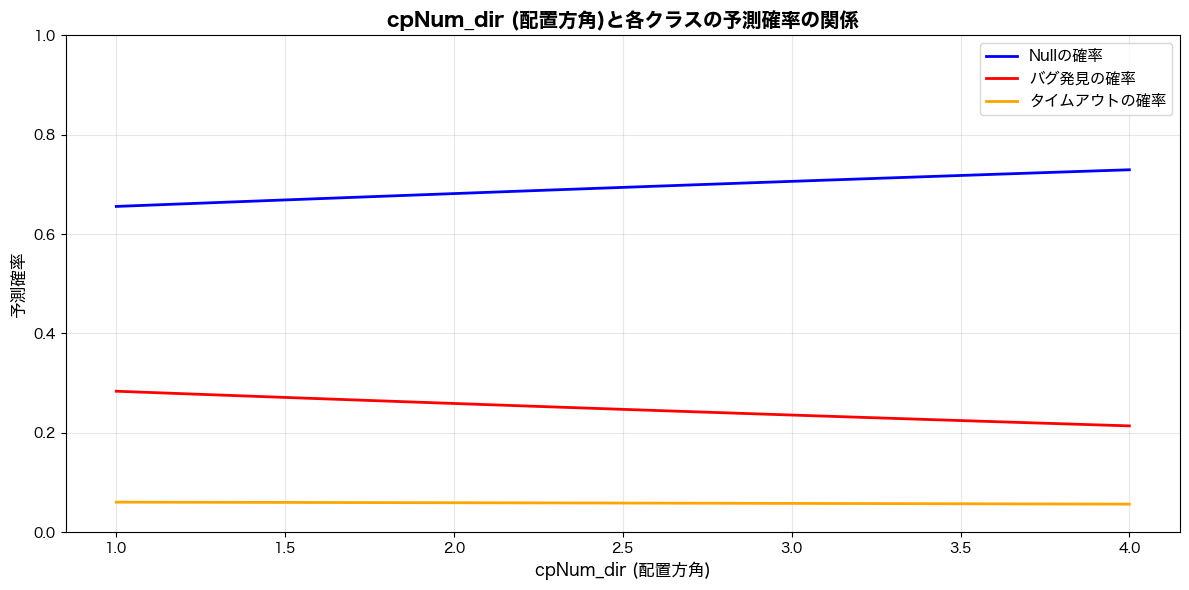

In [584]:
# ロジスティック回帰曲線の可視化（各説明変数ごとに別々の画像）
print("\n" + "="*70)
print("ロジスティック回帰曲線（実行結果の分類）")
print("="*70)

# 各変数の平均値
mean_tree = df['tree'].mean()
mean_cpNum = df['cpNum'].mean()
mean_cpNum_range = df['cpNum_range'].mean()
mean_cpNum_dir = df['cpNum_dir'].mean()

variables = ['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']
var_labels = ['tree (木の数)', 'cpNum (チェックポイント数)', 'cpNum_range (配置範囲)', 'cpNum_dir (配置方角)']
mean_values = [mean_tree, mean_cpNum, mean_cpNum_range, mean_cpNum_dir]
classes = ['normal', 'bug', 'timeout']
class_names = ['Null', 'バグ発見', 'タイムアウト']
colors = ['blue', 'red', 'orange']

for var, label, mean_val in zip(variables, var_labels, mean_values):
    # 変数の範囲を取得
    var_min = df[var].min()
    var_max = df[var].max()
    var_range = np.linspace(var_min, var_max, 100)
    
    # 各クラスの予測確率を計算
    predictions = {cls: [] for cls in classes}
    for val in var_range:
        # 他の変数は平均値に固定
        X_pred = pd.DataFrame({
            'tree': [mean_tree if var != 'tree' else val],
            'cpNum': [mean_cpNum if var != 'cpNum' else val],
            'cpNum_range': [mean_cpNum_range if var != 'cpNum_range' else val],
            'cpNum_dir': [mean_cpNum_dir if var != 'cpNum_dir' else val]
        })
        # 標準化
        X_pred_scaled = scaler.transform(X_pred)
        # 予測確率
        pred_proba = lr_model.predict_proba(X_pred_scaled)[0]
        for idx, cls in enumerate(classes):
            predictions[cls].append(pred_proba[idx])
    
    # 個別のグラフを描画
    plt.figure(figsize=(12, 6))
    for idx, (cls, cls_name, color) in enumerate(zip(classes, class_names, colors)):
        plt.plot(var_range, predictions[cls], color=color, linewidth=2, label=f'{cls_name}の確率')
    
    # 実際のデータポイントをプロット（各クラスごとに、確率として）
    # データが多い場合はサンプリング
    sample_size = min(1000, len(df))
    if len(df) > sample_size:
        df_sample = df.sample(n=sample_size, random_state=42)
    else:
        df_sample = df
    
    for idx, (cls, cls_name, color) in enumerate(zip(classes, class_names, colors)):
        mask = (df_sample['result_category'] == cls)
        if mask.sum() > 0:
            # 各クラスの確率を計算
            X_sample = df_sample[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
            X_sample_scaled = scaler.transform(X_sample)
            pred_proba_sample = lr_model.predict_proba(X_sample_scaled)
            
            # 該当クラスの確率を取得
            cls_idx = list(lr_model.classes_).index(cls)
            cls_proba = pred_proba_sample[:, cls_idx]
            
            # plt.scatter(df_sample.loc[mask, var], 
            #            cls_proba[mask.values], 
            #            alpha=0.2, s=15, c=color, label=f'{cls_name}のデータ' if idx == 0 else '')
    
    plt.xlabel(label, fontsize=12)
    plt.ylabel('予測確率', fontsize=12)
    plt.title(f'{label}と各クラスの予測確率の関係', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.show()


In [585]:
# 多クラスロジスティック回帰の係数と式の表示

print("="*70)
print("【多クラスロジスティック回帰の係数と式】")
print("="*70)

# モデルの係数と切片を取得
coefficients = lr_model.coef_  # 形状: (n_classes, n_features)
intercepts = lr_model.intercept_  # 形状: (n_classes,)
class_names = ['normal', 'bug', 'timeout']
class_labels = ['Null', 'バグ発見', 'タイムアウト']
feature_names = ['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']

# 標準化パラメータを取得
scaler_mean = scaler.mean_
scaler_scale = scaler.scale_

print("\n【標準化パラメータ】")
print("平均値:")
for i, name in enumerate(feature_names):
    print(f"  {name}: {scaler_mean[i]:.4f}")
print("\n標準偏差:")
for i, name in enumerate(feature_names):
    print(f"  {name}: {scaler_scale[i]:.4f}")

print("\n" + "="*70)
print("【標準化されたデータに対する係数】")
print("="*70)
print("（sklearnのモデルは標準化されたデータで学習されています）\n")

for class_idx, (cls, cls_label) in enumerate(zip(class_names, class_labels)):
    print(f"\n【{cls_label}クラス】")
    print(f"切片 (intercept): {intercepts[class_idx]:.6f}")
    print("係数:")
    for feat_idx, feat_name in enumerate(feature_names):
        print(f"  {feat_name}: {coefficients[class_idx, feat_idx]:.6f}")

print("\n" + "="*70)
print("【元のスケールでの係数（標準化の逆変換）】")
print("="*70)
print("（元のパラメータのスケールで直接使用できる式）\n")

# 標準化の逆変換: 元のスケールでの係数を計算
# 標準化: z = (x - mean) / scale
# ロジット: logit = intercept + coef1*z1 + coef2*z2 + ...
#         = intercept + coef1*(x1-mean1)/scale1 + coef2*(x2-mean2)/scale2 + ...
#         = (intercept - Σ(coef_i * mean_i / scale_i)) + Σ(coef_i / scale_i * x_i)

original_coefficients = {}
original_intercepts = {}

for class_idx, (cls, cls_label) in enumerate(zip(class_names, class_labels)):
    # 元のスケールでの係数 = 標準化された係数 / 標準偏差
    orig_coef = coefficients[class_idx] / scaler_scale
    
    # 元のスケールでの切片 = 標準化された切片 - Σ(係数 * 平均 / 標準偏差)
    orig_intercept = intercepts[class_idx] - np.sum(coefficients[class_idx] * scaler_mean / scaler_scale)
    
    original_coefficients[cls] = orig_coef
    original_intercepts[cls] = orig_intercept
    
    print(f"\n【{cls_label}クラス】")
    print(f"切片: {orig_intercept:.6f}")
    print("係数:")
    for feat_idx, feat_name in enumerate(feature_names):
        print(f"  {feat_name}: {orig_coef[feat_idx]:.6f}")

print("\n" + "="*70)
print("【各クラスのロジット関数（式）】")
print("="*70)
print("（元のパラメータのスケールで使用可能）\n")

for cls, cls_label in zip(class_names, class_labels):
    coef = original_coefficients[cls]
    intercept = original_intercepts[cls]
    
    print(f"\n【{cls_label}クラスのロジット関数】")
    
    # 1行の式として表示（切片と係数をすべて含む）
    formula_parts = [f"{intercept:.6f}"]
    for feat_idx, feat_name in enumerate(feature_names):
        sign = " + " if coef[feat_idx] >= 0 else " - "
        abs_coef = abs(coef[feat_idx])
        formula_parts.append(f"{sign}{abs_coef:.6f} × {feat_name}")
    
    formula = "".join(formula_parts)
    print(f"logit_{cls} = {formula}")
    
    # より読みやすい形式でも表示
    print(f"\n  展開形式:")
    print(f"  logit_{cls} = {intercept:.6f}", end="")
    for feat_idx, feat_name in enumerate(feature_names):
        sign = " + " if coef[feat_idx] >= 0 else " - "
        abs_coef = abs(coef[feat_idx])
        print(f"{sign}{abs_coef:.6f} × {feat_name}", end="")
    print()

print("\n" + "="*70)
print("【確率の計算式（ソフトマックス関数）】")
print("="*70)
print("""
各クラスの確率は、ソフトマックス関数で計算されます：

P(Null) = exp(logit_normal) / (exp(logit_normal) + exp(logit_bug) + exp(logit_timeout))
P(バグ発見) = exp(logit_bug) / (exp(logit_normal) + exp(logit_bug) + exp(logit_timeout))
P(タイムアウト) = exp(logit_timeout) / (exp(logit_normal) + exp(logit_bug) + exp(logit_timeout))

予測されるクラスは、確率が最も高いクラスです。
""")

print("\n" + "="*70)
print("【使用例】")
print("="*70)
print("""
例: tree=500, cpNum=200, cpNum_range=50, cpNum_dir=2 の場合

1. 各クラスのロジットを計算:
   logit_normal = (切片) + (係数_tree) × 500 + (係数_cpNum) × 200 + ...
   logit_bug = (切片) + (係数_tree) × 500 + (係数_cpNum) × 200 + ...
   logit_timeout = (切片) + (係数_tree) × 500 + (係数_cpNum) × 200 + ...

2. 各クラスの確率を計算:
   P(Null) = exp(logit_normal) / (exp(logit_normal) + exp(logit_bug) + exp(logit_timeout))
   P(バグ発見) = exp(logit_bug) / (exp(logit_normal) + exp(logit_bug) + exp(logit_timeout))
   P(タイムアウト) = exp(logit_timeout) / (exp(logit_normal) + exp(logit_bug) + exp(logit_timeout))

3. 最も確率が高いクラスが予測結果となります。
""")

# 検証: 実際に計算して確認
print("\n" + "="*70)
print("【検証: 実際の計算例】")
print("="*70)

test_params = {
    'tree': 500,
    'cpNum': 200,
    'cpNum_range': 50,
    'cpNum_dir': 2
}

print(f"\nパラメータ: {test_params}")

# ロジットを計算
logits = {}
for cls_idx, cls in enumerate(class_names):
    coef = original_coefficients[cls]
    intercept = original_intercepts[cls]
    logit = intercept
    logit += coef[0] * test_params['tree']
    logit += coef[1] * test_params['cpNum']
    logit += coef[2] * test_params['cpNum_range']
    logit += coef[3] * test_params['cpNum_dir']
    logits[cls] = logit
    cls_label = class_labels[cls_idx]
    
    # 具体的な計算式を表示
    print(f"\n【{cls_label}のロジット計算】")
    print(f"logit_{cls} = {intercept:.6f}", end="")
    print(f" + {coef[0]:.6f} × {test_params['tree']}", end="")
    print(f" + {coef[1]:.6f} × {test_params['cpNum']}", end="")
    print(f" + {coef[2]:.6f} × {test_params['cpNum_range']}", end="")
    print(f" + {coef[3]:.6f} × {test_params['cpNum_dir']}")
    
    # 計算結果を表示
    term1 = intercept
    term2 = coef[0] * test_params['tree']
    term3 = coef[1] * test_params['cpNum']
    term4 = coef[2] * test_params['cpNum_range']
    term5 = coef[3] * test_params['cpNum_dir']
    print(f"         = {term1:.6f} + {term2:.6f} + {term3:.6f} + {term4:.6f} + {term5:.6f}")
    print(f"         = {logit:.6f}")

# 確率を計算
exp_logits = {cls: np.exp(logit) for cls, logit in logits.items()}
sum_exp = sum(exp_logits.values())
probs = {cls: exp / sum_exp for cls, exp in exp_logits.items()}

print("\n計算された確率:")
for cls, cls_label in zip(class_names, class_labels):
    print(f"  {cls_label}: {probs[cls]:.4f} ({probs[cls]*100:.2f}%)")

# モデルでの予測と比較
X_test_manual = pd.DataFrame([test_params])
X_test_manual_scaled = scaler.transform(X_test_manual)
pred_proba_manual = lr_model.predict_proba(X_test_manual_scaled)[0]

print("\nモデルでの予測確率（検証用）:")
for cls_idx, cls_label in enumerate(class_labels):
    print(f"  {cls_label}: {pred_proba_manual[cls_idx]:.4f} ({pred_proba_manual[cls_idx]*100:.2f}%)")

print("\n（注: 標準化の逆変換による計算とモデルの予測が一致することを確認）")


【多クラスロジスティック回帰の係数と式】

【標準化パラメータ】
平均値:
  tree: 497.5694
  cpNum: 225.1890
  cpNum_range: 50.0284
  cpNum_dir: 1.1505

標準偏差:
  tree: 407.0344
  cpNum: 234.2254
  cpNum_range: 40.0118
  cpNum_dir: 0.5744

【標準化されたデータに対する係数】
（sklearnのモデルは標準化されたデータで学習されています）


【Nullクラス】
切片 (intercept): 1.081666
係数:
  tree: 0.089598
  cpNum: 0.156752
  cpNum_range: 0.570380
  cpNum_dir: 0.035980

【バグ発見クラス】
切片 (intercept): 0.223466
係数:
  tree: 0.065242
  cpNum: -0.516924
  cpNum_range: -1.172265
  cpNum_dir: -0.038421

【タイムアウトクラス】
切片 (intercept): -1.305132
係数:
  tree: -0.154839
  cpNum: 0.360172
  cpNum_range: 0.601885
  cpNum_dir: 0.002441

【元のスケールでの係数（標準化の逆変換）】
（元のパラメータのスケールで直接使用できる式）


【Nullクラス】
切片: 0.036200
係数:
  tree: 0.000220
  cpNum: 0.000669
  cpNum_range: 0.014255
  cpNum_dir: 0.062641

【バグ発見クラス】
切片: 2.183380
係数:
  tree: 0.000160
  cpNum: -0.002207
  cpNum_range: -0.029298
  cpNum_dir: -0.066891

【タイムアウトクラス】
切片: -2.219580
係数:
  tree: -0.000380
  cpNum: 0.001538
  cpNum_range: 0.015043
  cpNum_dir: 0.0

In [586]:
# 多クラスロジスティック回帰のオッズ比（相対リスク比）の計算と表示

print("="*70)
print("【実行結果の分類：オッズ比（相対リスク比）】")
print("="*70)
print("基準カテゴリ（ベースライン）に対する、各カテゴリの相対的なリスク比を表示します。\n")

# 基準カテゴリの設定（例: 'normal'）
ref_class = 'normal'
ref_label = 'Null（正常終了）'

# 基準カテゴリの係数を取得
if ref_class in original_coefficients:
    ref_coef = original_coefficients[ref_class]
    
    feature_names = ['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']
    class_names = ['normal', 'bug', 'timeout']
    class_labels = ['Null', 'バグ発見', 'タイムアウト']

    for cls, cls_label in zip(class_names, class_labels):
        if cls == ref_class:
            continue
        
        print(f"\n【{cls_label} vs {ref_label}】")
        
        # 係数の差分（対数オッズ比）
        diff_coef = original_coefficients[cls] - ref_coef
        
        # オッズ比（相対リスク比）
        odds_ratios = np.exp(diff_coef)
        
        for i, name in enumerate(feature_names):
            or_val = odds_ratios[i]
            print(f"  {name}: {or_val:.4f}")
            
            if or_val > 1:
                print(f"    → {name}が1増えると、{ref_label}に対して{cls_label}になるオッズが {(or_val-1)*100:.2f}% 増加")
            elif or_val < 1:
                print(f"    → {name}が1増えると、{ref_label}に対して{cls_label}になるオッズが {(1-or_val)*100:.2f}% 減少")
else:
    print(f"Error: 基準クラス {ref_class} の係数が見つかりません。前のセルを実行して original_coefficients を作成してください。")


【実行結果の分類：オッズ比（相対リスク比）】
基準カテゴリ（ベースライン）に対する、各カテゴリの相対的なリスク比を表示します。


【バグ発見 vs Null（正常終了）】
  tree: 0.9999
    → treeが1増えると、Null（正常終了）に対してバグ発見になるオッズが 0.01% 減少
  cpNum: 0.9971
    → cpNumが1増えると、Null（正常終了）に対してバグ発見になるオッズが 0.29% 減少
  cpNum_range: 0.9574
    → cpNum_rangeが1増えると、Null（正常終了）に対してバグ発見になるオッズが 4.26% 減少
  cpNum_dir: 0.8785
    → cpNum_dirが1増えると、Null（正常終了）に対してバグ発見になるオッズが 12.15% 減少

【タイムアウト vs Null（正常終了）】
  tree: 0.9994
    → treeが1増えると、Null（正常終了）に対してタイムアウトになるオッズが 0.06% 減少
  cpNum: 1.0009
    → cpNumが1増えると、Null（正常終了）に対してタイムアウトになるオッズが 0.09% 増加
  cpNum_range: 1.0008
    → cpNum_rangeが1増えると、Null（正常終了）に対してタイムアウトになるオッズが 0.08% 増加
  cpNum_dir: 0.9433
    → cpNum_dirが1増えると、Null（正常終了）に対してタイムアウトになるオッズが 5.67% 減少


In [587]:
# パラメータから実行結果を予測する関数

def predict_result(tree, cpNum, cpNum_range, cpNum_dir):
    """
    パラメータから実行結果を予測する関数
    
    Args:
        tree: 木の数 (0, 500, 1000)
        cpNum: チェックポイント数 (1, 50, 99, 200, 300, 700)
        cpNum_range: チェックポイントの配置範囲 (1, 50, 99)
        cpNum_dir: チェックポイントの配置方角 (1, 2, 3, 4)
    
    Returns:
        dict: 予測結果と各クラスの確率
    """
    # 予測用データの準備
    X_pred = pd.DataFrame({
        'tree': [tree],
        'cpNum': [cpNum],
        'cpNum_range': [cpNum_range],
        'cpNum_dir': [cpNum_dir]
    })
    
    # 標準化（訓練データと同じスケーラーを使用）
    X_pred_scaled = scaler.transform(X_pred)
    
    # 予測
    y_pred = lr_model.predict(X_pred_scaled)[0]
    y_pred_proba = lr_model.predict_proba(X_pred_scaled)[0]
    
    # クラス名のマッピング
    class_mapping = {
        'normal': '正常終了（Null）',
        'bug': 'バグ発見',
        'timeout': 'タイムアウト'
    }
    
    # 結果の整理
    result = {
        '予測結果': class_mapping.get(y_pred, y_pred),
        '各クラスの確率': {}
    }
    
    for cls, proba in zip(lr_model.classes_, y_pred_proba):
        cls_name = class_mapping.get(cls, cls)
        result['各クラスの確率'][cls_name] = f"{proba:.4f} ({proba*100:.2f}%)"
    
    return result

# 使用例
print("="*70)
print("【パラメータから実行結果を予測】")
print("="*70)

# 例1: 最小パラメータ
print("\n例1: 最小パラメータ")
print("  tree=0, cpNum=1, cpNum_range=1, cpNum_dir=1")
result1 = predict_result(tree=0, cpNum=1, cpNum_range=1, cpNum_dir=1)
print(f"  予測結果: {result1['予測結果']}")
print("  各クラスの確率:")
for cls, proba in result1['各クラスの確率'].items():
    print(f"    {cls}: {proba}")

# 例2: 中程度パラメータ
print("\n例2: 中程度パラメータ")
print("  tree=500, cpNum=200, cpNum_range=50, cpNum_dir=2")
result2 = predict_result(tree=500, cpNum=200, cpNum_range=50, cpNum_dir=2)
print(f"  予測結果: {result2['予測結果']}")
print("  各クラスの確率:")
for cls, proba in result2['各クラスの確率'].items():
    print(f"    {cls}: {proba}")

# 例3: 最大パラメータ
print("\n例3: 最大パラメータ")
print("  tree=1000, cpNum=700, cpNum_range=99, cpNum_dir=4")
result3 = predict_result(tree=1000, cpNum=700, cpNum_range=99, cpNum_dir=4)
print(f"  予測結果: {result3['予測結果']}")
print("  各クラスの確率:")
for cls, proba in result3['各クラスの確率'].items():
    print(f"    {cls}: {proba}")

# 例4: 高チェックポイント数
print("\n例4: 高チェックポイント数")
print("  tree=0, cpNum=300, cpNum_range=99, cpNum_dir=1")
result4 = predict_result(tree=0, cpNum=300, cpNum_range=99, cpNum_dir=1)
print(f"  予測結果: {result4['予測結果']}")
print("  各クラスの確率:")
for cls, proba in result4['各クラスの確率'].items():
    print(f"    {cls}: {proba}")

# 例5: 高木数・低チェックポイント
print("\n例5: 高木数・低チェックポイント")
print("  tree=1000, cpNum=50, cpNum_range=1, cpNum_dir=1")
result5 = predict_result(tree=1000, cpNum=50, cpNum_range=1, cpNum_dir=1)
print(f"  予測結果: {result5['予測結果']}")
print("  各クラスの確率:")
for cls, proba in result5['各クラスの確率'].items():
    print(f"    {cls}: {proba}")

print("\n" + "="*70)
print("【使い方】")
print("="*70)
print("predict_result(tree, cpNum, cpNum_range, cpNum_dir) 関数を使用して、")
print("任意のパラメータから実行結果を予測できます。")
print("\n例:")
print("  result = predict_result(tree=500, cpNum=200, cpNum_range=50, cpNum_dir=2)")
print("  print(result['予測結果'])")
print("  print(result['各クラスの確率'])")


【パラメータから実行結果を予測】

例1: 最小パラメータ
  tree=0, cpNum=1, cpNum_range=1, cpNum_dir=1
  予測結果: 正常終了（Null）
  各クラスの確率:
    バグ発見: 0.1208 (12.08%)
    正常終了（Null）: 0.8672 (86.72%)
    タイムアウト: 0.0120 (1.20%)

例2: 中程度パラメータ
  tree=500, cpNum=200, cpNum_range=50, cpNum_dir=2
  予測結果: バグ発見
  各クラスの確率:
    バグ発見: 0.6693 (66.93%)
    正常終了（Null）: 0.2735 (27.35%)
    タイムアウト: 0.0572 (5.72%)

例3: 最大パラメータ
  tree=1000, cpNum=700, cpNum_range=99, cpNum_dir=4
  予測結果: バグ発見
  各クラスの確率:
    バグ発見: 0.9100 (91.00%)
    正常終了（Null）: 0.0078 (0.78%)
    タイムアウト: 0.0822 (8.22%)

例4: 高チェックポイント数
  tree=0, cpNum=300, cpNum_range=99, cpNum_dir=1
  予測結果: バグ発見
  各クラスの確率:
    バグ発見: 0.8466 (84.66%)
    正常終了（Null）: 0.0360 (3.60%)
    タイムアウト: 0.1174 (11.74%)

例5: 高木数・低チェックポイント
  tree=1000, cpNum=50, cpNum_range=1, cpNum_dir=1
  予測結果: 正常終了（Null）
  各クラスの確率:
    バグ発見: 0.1443 (14.43%)
    正常終了（Null）: 0.8475 (84.75%)
    タイムアウト: 0.0082 (0.82%)

【使い方】
predict_result(tree, cpNum, cpNum_range, cpNum_dir) 関数を使用して、
任意のパラメータから実行結果を予測できます。

例:
  result 

## 3-1. 実行結果の分類：適合度評価指標

多クラス分類モデルの適合度を評価します。


In [588]:
# 3-1. 実行結果の分類：適合度評価指標

from sklearn.metrics import cohen_kappa_score, log_loss

print("="*70)
print("【実行結果の分類】適合度評価指標")
print("="*70)

# 既存のモデルを使用（Cell 10で作成済み）
# 予測確率を取得
y_pred_proba_multiclass = lr_model.predict_proba(X_test_scaled)

# ===== 1. Cohen's Kappa（クラス不均衡を考慮） =====
print("\n" + "="*70)
print("【1. Cohen's Kappa（クラス不均衡を考慮）】")
print("="*70)
kappa = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa: {kappa:.4f}")
print(f"  → 1に近いほど良い（0.6以上で実用的、0.8以上で優秀）")
print(f"  → 現在の値は{'優秀' if kappa > 0.8 else '良好' if kappa > 0.6 else 'やや低い' if kappa > 0.4 else '改善の余地あり'}")

# Kappaの解釈
print(f"\nKappaの解釈:")
if kappa < 0:
    print("  → 一致度が偶然以下（非常に悪い）")
elif kappa < 0.2:
    print("  → ほとんど一致していない")
elif kappa < 0.4:
    print("  → やや一致している")
elif kappa < 0.6:
    print("  → 中程度に一致している")
elif kappa < 0.8:
    print("  → かなり一致している")
else:
    print("  → ほぼ完全に一致している")

# ===== 2. Log Loss（対数損失） =====
print("\n" + "="*70)
print("【2. Log Loss（対数損失）】")
print("="*70)
log_loss_multiclass = log_loss(y_test, y_pred_proba_multiclass)
print(f"Log Loss: {log_loss_multiclass:.4f}")
print(f"  → 0に近いほど良い")
print(f"  → 現在の値は{'良好' if log_loss_multiclass < 0.5 else 'やや高い' if log_loss_multiclass < 1.0 else '改善の余地あり'}")

# Log Lossの解釈
print(f"\nLog Lossの解釈:")
print(f"  → 予測確率と実際の結果の不一致度を表す")
print(f"  → 完全に正しい予測の場合: 0.0")
print(f"  → ランダム予測の場合: 約{np.log(len(lr_model.classes_)):.4f} (クラス数={len(lr_model.classes_)})")
print(f"  → 現在のモデルはランダム予測より{'優れている' if log_loss_multiclass < np.log(len(lr_model.classes_)) else '劣っている'}")

# 各クラスのLog Lossを計算
print(f"\n各クラスのLog Loss:")
for i, cls in enumerate(lr_model.classes_):
    # 各クラスのバイナリラベルを作成
    y_test_binary = (y_test == cls).astype(int)
    y_pred_proba_binary = y_pred_proba_multiclass[:, i]
    cls_log_loss = log_loss(y_test_binary, y_pred_proba_binary)
    cls_name = {'normal': 'Null', 'bug': 'バグ発見', 'timeout': 'タイムアウト'}.get(cls, cls)
    print(f"  {cls_name}: {cls_log_loss:.4f}")


【実行結果の分類】適合度評価指標

【1. Cohen's Kappa（クラス不均衡を考慮）】
Cohen's Kappa: 0.5171
  → 1に近いほど良い（0.6以上で実用的、0.8以上で優秀）
  → 現在の値はやや低い

Kappaの解釈:
  → 中程度に一致している

【2. Log Loss（対数損失）】
Log Loss: 0.6156
  → 0に近いほど良い
  → 現在の値はやや高い

Log Lossの解釈:
  → 予測確率と実際の結果の不一致度を表す
  → 完全に正しい予測の場合: 0.0
  → ランダム予測の場合: 約1.0986 (クラス数=3)
  → 現在のモデルはランダム予測より優れている

各クラスのLog Loss:
  バグ発見: 0.5090
  Null: 0.4221
  タイムアウト: 0.2066


## 4. バグ発見数のカテゴリ分類（多クラス分類）のロジスティック回帰分析

バグ発見数をカテゴリ化し、パラメータからバグ発見数のカテゴリを予測します。


In [589]:
# 4. バグ発見数のカテゴリ分類（多クラス分類）のロジスティック回帰分析

# まず、パラメータディレクトリごとのバグ発見数を集計
def collect_bug_count_data(logs_root='Logs'):
    """
    パラメータディレクトリごとのバグ発見数を集計
    """
    data_records = []
    logs_path = Path(logs_root)
    
    for tree_dir in logs_path.glob('tree=*'):
        tree_value = int(tree_dir.name.split('=')[1])
        
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir():
                continue
            
            cpnum, cpnum_range, cpnum_dir = parse_directory_name(param_dir.name)
            if cpnum is None or cpnum_range is None or cpnum_dir is None:
                continue
            
            detected_bugs_path = param_dir / 'detected_bugs.csv'
            if not os.path.exists(detected_bugs_path):
                continue
            
            # バグ発見数をカウント
            bug_count = 0
            with open(detected_bugs_path, 'r') as bug_f:
                bug_reader = csv.reader(bug_f)
                for bug_row in bug_reader:
                    if bug_row != ['null'] and bug_row != ['timeout']:
                        bug_count += 1
            
            data_records.append({
                'tree': tree_value,
                'cpNum': cpnum,
                'cpNum_range': cpnum_range,
                'cpNum_dir': cpnum_dir,
                'bug_count': bug_count
            })
    
    return pd.DataFrame(data_records)

df_bug_count = collect_bug_count_data()
print(f"データ収集完了: {len(df_bug_count)}件のレコード")
print(f"\nバグ発見数の分布:")
print(df_bug_count['bug_count'].value_counts().sort_index())

# バグ発見数をカテゴリ化（例：0-1個、2-3個、4-5個）
def categorize_bug_count(count):
    if count <= 1:
        return '0-1個'
    elif count <= 3:
        return '2-3個'
    else:
        return '4-5個'

df_bug_count['bug_count_category'] = df_bug_count['bug_count'].apply(categorize_bug_count)
print(f"\nバグ発見数のカテゴリ分布:")
print(df_bug_count['bug_count_category'].value_counts())


データ収集完了: 2160件のレコード

バグ発見数の分布:
bug_count
0    336
1    414
2    223
3    148
4    276
5    763
Name: count, dtype: int64

バグ発見数のカテゴリ分布:
bug_count_category
4-5個    1039
0-1個     750
2-3個     371
Name: count, dtype: int64


【バグ発見数のカテゴリ分類】多クラスロジスティック回帰分析結果

分類レポート:
              precision    recall  f1-score   support

        0-1個       0.73      0.89      0.80       150
        2-3個       1.00      0.01      0.03        74
        4-5個       0.77      0.92      0.84       208

    accuracy                           0.75       432
   macro avg       0.83      0.61      0.56       432
weighted avg       0.80      0.75      0.69       432


混同行列:
[[133   0  17]
 [ 34   1  39]
 [ 16   0 192]]


/Users/yamaguchiyusei/programming/localfuzz_analysis/venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


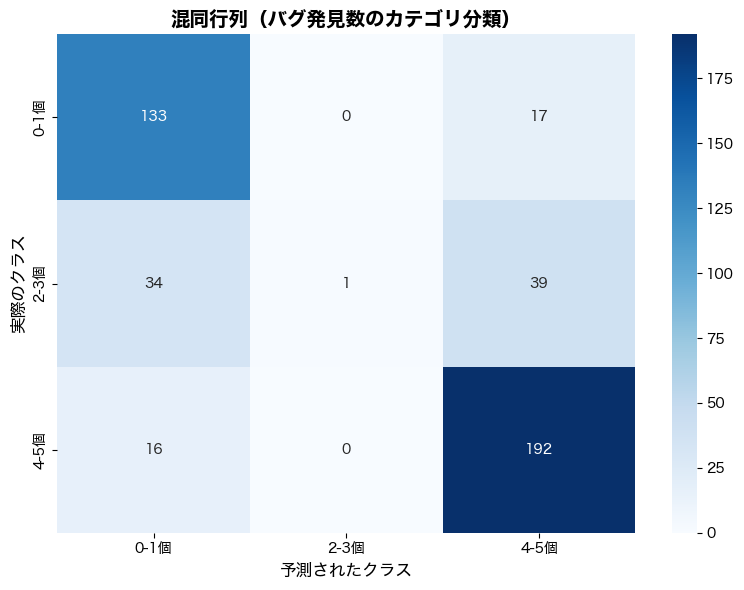

In [590]:
# 多クラスロジスティック回帰分析
X = df_bug_count[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y = df_bug_count['bug_count_category']

# データを訓練用とテスト用に分割
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 多クラスロジスティック回帰モデルの学習
lr_model = LogisticRegression(random_state=42, max_iter=1000, multi_class='multinomial', solver='lbfgs')
lr_model.fit(X_train_scaled, y_train)

# 予測
y_pred = lr_model.predict(X_test_scaled)
y_pred_proba = lr_model.predict_proba(X_test_scaled)

# 評価指標
print("="*70)
print("【バグ発見数のカテゴリ分類】多クラスロジスティック回帰分析結果")
print("="*70)
print("\n分類レポート:")
print(classification_report(y_test, y_pred))

print("\n混同行列:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# 混同行列の可視化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=lr_model.classes_,
            yticklabels=lr_model.classes_)
plt.title('混同行列（バグ発見数のカテゴリ分類）', fontsize=14, fontweight='bold')
plt.ylabel('実際のクラス', fontsize=12)
plt.xlabel('予測されたクラス', fontsize=12)
plt.tight_layout()
plt.show()


In [591]:
# バグ発見数のカテゴリ分類の多クラスロジスティック回帰の係数と式の表示

print("="*70)
print("【バグ発見数のカテゴリ分類：多クラスロジスティック回帰の係数と式】")
print("="*70)

# モデルの係数と切片を取得
coefficients = lr_model.coef_  # 形状: (n_classes, n_features)
intercepts = lr_model.intercept_  # 形状: (n_classes,)
class_names = lr_model.classes_  # カテゴリ名
feature_names = ['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']

# 標準化パラメータを取得
scaler_mean = scaler.mean_
scaler_scale = scaler.scale_

print("\n【標準化パラメータ】")
print("平均値:")
for i, name in enumerate(feature_names):
    print(f"  {name}: {scaler_mean[i]:.4f}")
print("\n標準偏差:")
for i, name in enumerate(feature_names):
    print(f"  {name}: {scaler_scale[i]:.4f}")

print("\n" + "="*70)
print("【標準化されたデータに対する係数】")
print("="*70)
print("（sklearnのモデルは標準化されたデータで学習されています）\n")

for class_idx, cls in enumerate(class_names):
    print(f"\n【{cls}カテゴリ】")
    print(f"切片 (intercept): {intercepts[class_idx]:.6f}")
    print("係数:")
    for feat_idx, feat_name in enumerate(feature_names):
        print(f"  {feat_name}: {coefficients[class_idx, feat_idx]:.6f}")

print("\n" + "="*70)
print("【元のスケールでの係数（標準化の逆変換）】")
print("="*70)
print("（元のパラメータのスケールで直接使用できる式）\n")

# 標準化の逆変換: 元のスケールでの係数を計算
# 標準化: z = (x - mean) / scale
# ロジット: logit = intercept + coef1*z1 + coef2*z2 + ...
#         = intercept + coef1*(x1-mean1)/scale1 + coef2*(x2-mean2)/scale2 + ...
#         = (intercept - Σ(coef_i * mean_i / scale_i)) + Σ(coef_i / scale_i * x_i)

original_coefficients = {}
original_intercepts = {}

for class_idx, cls in enumerate(class_names):
    # 元のスケールでの係数 = 標準化された係数 / 標準偏差
    orig_coef = coefficients[class_idx] / scaler_scale
    
    # 元のスケールでの切片 = 標準化された切片 - Σ(係数 * 平均 / 標準偏差)
    orig_intercept = intercepts[class_idx] - np.sum(coefficients[class_idx] * scaler_mean / scaler_scale)
    
    original_coefficients[cls] = orig_coef
    original_intercepts[cls] = orig_intercept
    
    print(f"\n【{cls}カテゴリ】")
    print(f"切片: {orig_intercept:.6f}")
    print("係数:")
    for feat_idx, feat_name in enumerate(feature_names):
        print(f"  {feat_name}: {orig_coef[feat_idx]:.6f}")

print("\n" + "="*70)
print("【各カテゴリのロジット関数（式）】")
print("="*70)
print("（元のパラメータのスケールで使用可能）\n")

for cls in class_names:
    coef = original_coefficients[cls]
    intercept = original_intercepts[cls]
    
    print(f"\n【{cls}カテゴリのロジット関数】")
    
    # 1行の式として表示（切片と係数をすべて含む）
    formula_parts = [f"{intercept:.6f}"]
    for feat_idx, feat_name in enumerate(feature_names):
        sign = " + " if coef[feat_idx] >= 0 else " - "
        abs_coef = abs(coef[feat_idx])
        formula_parts.append(f"{sign}{abs_coef:.6f} × {feat_name}")
    
    formula = "".join(formula_parts)
    print(f"logit_{cls} = {formula}")
    
    # より読みやすい形式でも表示
    print(f"\n  展開形式:")
    print(f"  logit_{cls} = {intercept:.6f}", end="")
    for feat_idx, feat_name in enumerate(feature_names):
        sign = " + " if coef[feat_idx] >= 0 else " - "
        abs_coef = abs(coef[feat_idx])
        print(f"{sign}{abs_coef:.6f} × {feat_name}", end="")
    print()

print("\n" + "="*70)
print("【確率の計算式（ソフトマックス関数）】")
print("="*70)
print("""
各カテゴリの確率は、ソフトマックス関数で計算されます：

P(0-1個) = exp(logit_0-1個) / (exp(logit_0-1個) + exp(logit_2-3個) + exp(logit_4-5個))
P(2-3個) = exp(logit_2-3個) / (exp(logit_0-1個) + exp(logit_2-3個) + exp(logit_4-5個))
P(4-5個) = exp(logit_4-5個) / (exp(logit_0-1個) + exp(logit_2-3個) + exp(logit_4-5個))

予測されるカテゴリは、確率が最も高いカテゴリです。
""")

print("\n" + "="*70)
print("【使用例】")
print("="*70)
print("""
例: tree=500, cpNum=200, cpNum_range=50, cpNum_dir=2 の場合

1. 各カテゴリのロジットを計算:
   logit_0-1個 = (切片) + (係数_tree) × 500 + (係数_cpNum) × 200 + ...
   logit_2-3個 = (切片) + (係数_tree) × 500 + (係数_cpNum) × 200 + ...
   logit_4-5個 = (切片) + (係数_tree) × 500 + (係数_cpNum) × 200 + ...

2. 各カテゴリの確率を計算:
   P(0-1個) = exp(logit_0-1個) / (exp(logit_0-1個) + exp(logit_2-3個) + exp(logit_4-5個))
   P(2-3個) = exp(logit_2-3個) / (exp(logit_0-1個) + exp(logit_2-3個) + exp(logit_4-5個))
   P(4-5個) = exp(logit_4-5個) / (exp(logit_0-1個) + exp(logit_2-3個) + exp(logit_4-5個))

3. 最も確率が高いカテゴリが予測結果となります。
""")

# 検証: 実際に計算して確認
print("\n" + "="*70)
print("【検証: 実際の計算例】")
print("="*70)

test_params = {
    'tree': 500,
    'cpNum': 200,
    'cpNum_range': 50,
    'cpNum_dir': 2
}

print(f"\nパラメータ: {test_params}")

# ロジットを計算
logits = {}
for class_idx, cls in enumerate(class_names):
    coef = original_coefficients[cls]
    intercept = original_intercepts[cls]
    logit = intercept
    logit += coef[0] * test_params['tree']
    logit += coef[1] * test_params['cpNum']
    logit += coef[2] * test_params['cpNum_range']
    logit += coef[3] * test_params['cpNum_dir']
    logits[cls] = logit
    
    # 具体的な計算式を表示
    print(f"\n【{cls}カテゴリのロジット計算】")
    print(f"logit_{cls} = {intercept:.6f}", end="")
    print(f" + {coef[0]:.6f} × {test_params['tree']}", end="")
    print(f" + {coef[1]:.6f} × {test_params['cpNum']}", end="")
    print(f" + {coef[2]:.6f} × {test_params['cpNum_range']}", end="")
    print(f" + {coef[3]:.6f} × {test_params['cpNum_dir']}")
    
    # 計算結果を表示
    term1 = intercept
    term2 = coef[0] * test_params['tree']
    term3 = coef[1] * test_params['cpNum']
    term4 = coef[2] * test_params['cpNum_range']
    term5 = coef[3] * test_params['cpNum_dir']
    print(f"         = {term1:.6f} + {term2:.6f} + {term3:.6f} + {term4:.6f} + {term5:.6f}")
    print(f"         = {logit:.6f}")

# 確率を計算
exp_logits = {cls: np.exp(logit) for cls, logit in logits.items()}
sum_exp = sum(exp_logits.values())
probs = {cls: exp / sum_exp for cls, exp in exp_logits.items()}

print("\n計算された確率:")
for cls in class_names:
    print(f"  {cls}: {probs[cls]:.4f} ({probs[cls]*100:.2f}%)")

# モデルでの予測と比較
X_test_manual = pd.DataFrame([test_params])
X_test_manual_scaled = scaler.transform(X_test_manual)
pred_proba_manual = lr_model.predict_proba(X_test_manual_scaled)[0]

print("\nモデルでの予測確率（検証用）:")
for class_idx, cls in enumerate(class_names):
    print(f"  {cls}: {pred_proba_manual[class_idx]:.4f} ({pred_proba_manual[class_idx]*100:.2f}%)")

print("\n（注: 標準化の逆変換による計算とモデルの予測が一致することを確認）")


【バグ発見数のカテゴリ分類：多クラスロジスティック回帰の係数と式】

【標準化パラメータ】
平均値:
  tree: 495.3704
  cpNum: 225.4091
  cpNum_range: 49.9149
  cpNum_dir: 1.1441

標準偏差:
  tree: 408.9302
  cpNum: 235.0315
  cpNum_range: 39.8168
  cpNum_dir: 0.5554

【標準化されたデータに対する係数】
（sklearnのモデルは標準化されたデータで学習されています）


【0-1個カテゴリ】
切片 (intercept): -0.149201
係数:
  tree: -0.025154
  cpNum: -0.364535
  cpNum_range: -1.085902
  cpNum_dir: -0.066971

【2-3個カテゴリ】
切片 (intercept): -0.284061
係数:
  tree: -0.018486
  cpNum: -0.090667
  cpNum_range: -0.061277
  cpNum_dir: 0.057491

【4-5個カテゴリ】
切片 (intercept): 0.433262
係数:
  tree: 0.043641
  cpNum: 0.455201
  cpNum_range: 1.147180
  cpNum_dir: 0.009480

【元のスケールでの係数（標準化の逆変換）】
（元のパラメータのスケールで直接使用できる式）


【0-1個カテゴリ】
切片: 1.730131
係数:
  tree: -0.000062
  cpNum: -0.001551
  cpNum_range: -0.027272
  cpNum_dir: -0.120572

【2-3個カテゴリ】
切片: -0.216313
係数:
  tree: -0.000045
  cpNum: -0.000386
  cpNum_range: -0.001539
  cpNum_dir: 0.103505

【4-5個カテゴリ】
切片: -1.513818
係数:
  tree: 0.000107
  cpNum: 0.001937
  cpNum_range: 0.

## 4-1. バグ発見数のカテゴリ分類：適合度評価指標

多クラス分類モデルの適合度を評価します。


In [592]:
# 4-1. バグ発見数のカテゴリ分類：適合度評価指標

print("="*70)
print("【バグ発見数のカテゴリ分類】適合度評価指標")
print("="*70)

# 既存のモデルを使用（Cell 15で作成済み）
# 予測確率を取得
y_pred_proba_bugcount = lr_model.predict_proba(X_test_scaled)

# ===== 1. Cohen's Kappa（クラス不均衡を考慮） =====
print("\n" + "="*70)
print("【1. Cohen's Kappa（クラス不均衡を考慮）】")
print("="*70)
kappa_bugcount = cohen_kappa_score(y_test, y_pred)
print(f"Cohen's Kappa: {kappa_bugcount:.4f}")
print(f"  → 1に近いほど良い（0.6以上で実用的、0.8以上で優秀）")
print(f"  → 現在の値は{'優秀' if kappa_bugcount > 0.8 else '良好' if kappa_bugcount > 0.6 else 'やや低い' if kappa_bugcount > 0.4 else '改善の余地あり'}")

# Kappaの解釈
print(f"\nKappaの解釈:")
if kappa_bugcount < 0:
    print("  → 一致度が偶然以下（非常に悪い）")
elif kappa_bugcount < 0.2:
    print("  → ほとんど一致していない")
elif kappa_bugcount < 0.4:
    print("  → やや一致している")
elif kappa_bugcount < 0.6:
    print("  → 中程度に一致している")
elif kappa_bugcount < 0.8:
    print("  → かなり一致している")
else:
    print("  → ほぼ完全に一致している")

# ===== 2. Log Loss（対数損失） =====
print("\n" + "="*70)
print("【2. Log Loss（対数損失）】")
print("="*70)
log_loss_bugcount = log_loss(y_test, y_pred_proba_bugcount)
print(f"Log Loss: {log_loss_bugcount:.4f}")
print(f"  → 0に近いほど良い")
print(f"  → 現在の値は{'良好' if log_loss_bugcount < 0.5 else 'やや高い' if log_loss_bugcount < 1.0 else '改善の余地あり'}")

# Log Lossの解釈
print(f"\nLog Lossの解釈:")
print(f"  → 予測確率と実際の結果の不一致度を表す")
print(f"  → 完全に正しい予測の場合: 0.0")
print(f"  → ランダム予測の場合: 約{np.log(len(lr_model.classes_)):.4f} (クラス数={len(lr_model.classes_)})")
print(f"  → 現在のモデルはランダム予測より{'優れている' if log_loss_bugcount < np.log(len(lr_model.classes_)) else '劣っている'}")

# 各クラスのLog Lossを計算
print(f"\n各クラスのLog Loss:")
for i, cls in enumerate(lr_model.classes_):
    # 各クラスのバイナリラベルを作成
    y_test_binary = (y_test == cls).astype(int)
    y_pred_proba_binary = y_pred_proba_bugcount[:, i]
    cls_log_loss = log_loss(y_test_binary, y_pred_proba_binary)
    print(f"  {cls}: {cls_log_loss:.4f}")


【バグ発見数のカテゴリ分類】適合度評価指標

【1. Cohen's Kappa（クラス不均衡を考慮）】
Cohen's Kappa: 0.5741
  → 1に近いほど良い（0.6以上で実用的、0.8以上で優秀）
  → 現在の値はやや低い

Kappaの解釈:
  → 中程度に一致している

【2. Log Loss（対数損失）】
Log Loss: 0.7238
  → 0に近いほど良い
  → 現在の値はやや高い

Log Lossの解釈:
  → 予測確率と実際の結果の不一致度を表す
  → 完全に正しい予測の場合: 0.0
  → ランダム予測の場合: 約1.0986 (クラス数=3)
  → 現在のモデルはランダム予測より優れている

各クラスのLog Loss:
  0-1個: 0.4179
  2-3個: 0.4595
  4-5個: 0.4294


## 4-2. バグ発見数の2クラス分類（少ない/多い）のロジスティック回帰分析

バグ発見数を2クラス（「少ない（0-3個）」「多い（4-5個）」）に分類し、パラメータからバグ発見数のカテゴリを予測します。


【バグ発見数の2クラス分類】データ準備

バグ発見数の2クラス分布:
bug_count_category_binary
少ない（0-3個）    1121
多い（4-5個）     1039
Name: count, dtype: int64

各クラスの割合:
bug_count_category_binary
少ない（0-3個）    0.518981
多い（4-5個）     0.481019
Name: proportion, dtype: float64

【バグ発見数の2クラス分類】ロジスティック回帰分析結果

分類レポート:
              precision    recall  f1-score   support

   少ない（0-3個）       0.77      0.66      0.71       208
    多い（4-5個）       0.72      0.81      0.76       224

    accuracy                           0.74       432
   macro avg       0.74      0.74      0.74       432
weighted avg       0.74      0.74      0.74       432


混同行列:
[[138  70]
 [ 42 182]]


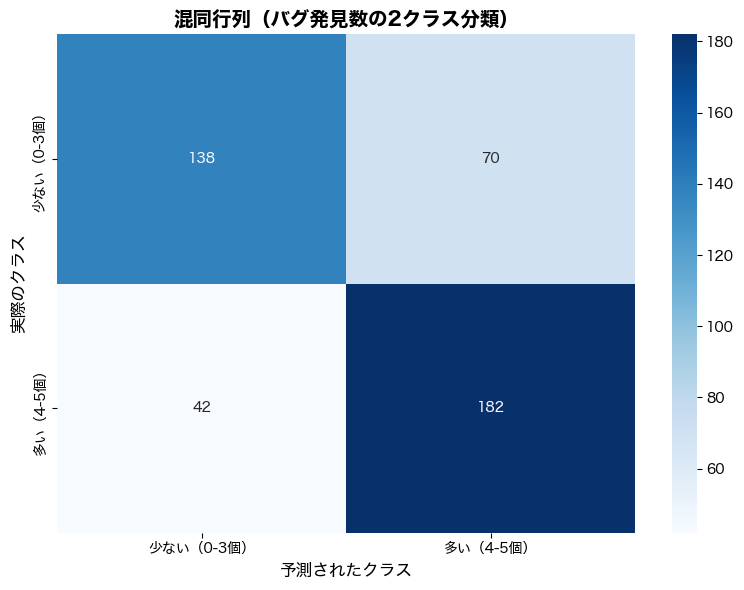

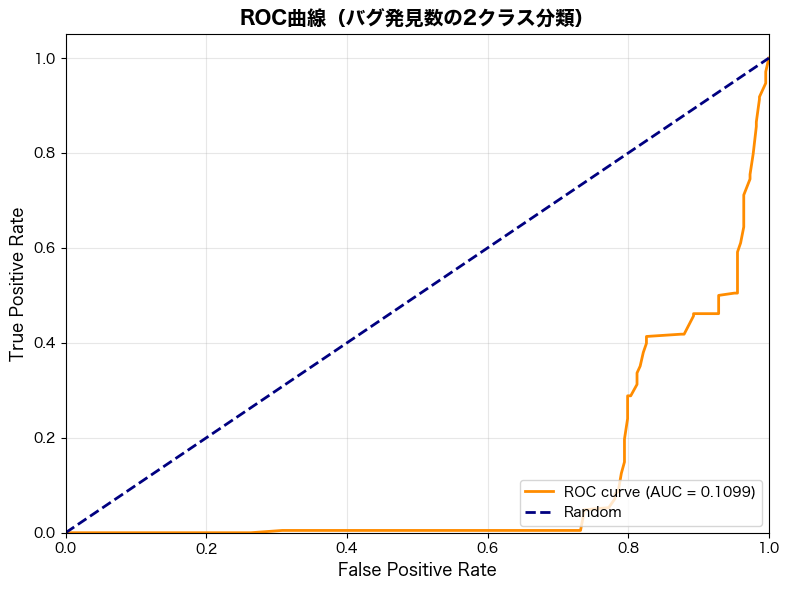


AUC: 0.1099


In [593]:
# 4-2. バグ発見数の2クラス分類（少ない/多い）のロジスティック回帰分析

# バグ発見数を2クラスにカテゴリ化（0-3個 = "少ない", 4-5個 = "多い"）
def categorize_bug_count_binary(count):
    if count <= 3:
        return '少ない（0-3個）'
    else:
        return '多い（4-5個）'

# 既存のdf_bug_countデータを使用して2クラス分類用のデータを作成
df_bug_count_binary = df_bug_count.copy()
df_bug_count_binary['bug_count_category_binary'] = df_bug_count_binary['bug_count'].apply(categorize_bug_count_binary)

print("="*70)
print("【バグ発見数の2クラス分類】データ準備")
print("="*70)
print(f"\nバグ発見数の2クラス分布:")
print(df_bug_count_binary['bug_count_category_binary'].value_counts())
print(f"\n各クラスの割合:")
print(df_bug_count_binary['bug_count_category_binary'].value_counts(normalize=True))

# 2クラスロジスティック回帰分析
X_binary = df_bug_count_binary[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
y_binary = df_bug_count_binary['bug_count_category_binary']

# データを訓練用とテスト用に分割
X_train_binary, X_test_binary, y_train_binary, y_test_binary = train_test_split(
    X_binary, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# 標準化
scaler_binary = StandardScaler()
X_train_binary_scaled = scaler_binary.fit_transform(X_train_binary)
X_test_binary_scaled = scaler_binary.transform(X_test_binary)

# 2クラスロジスティック回帰モデルの学習
lr_model_binary = LogisticRegression(random_state=42, max_iter=1000)
lr_model_binary.fit(X_train_binary_scaled, y_train_binary)

# 予測
y_pred_binary = lr_model_binary.predict(X_test_binary_scaled)
y_pred_proba_binary = lr_model_binary.predict_proba(X_test_binary_scaled)[:, 1]

# 評価指標
print("\n" + "="*70)
print("【バグ発見数の2クラス分類】ロジスティック回帰分析結果")
print("="*70)
print("\n分類レポート:")
print(classification_report(y_test_binary, y_pred_binary, target_names=['少ない（0-3個）', '多い（4-5個）']))

print("\n混同行列:")
cm_binary = confusion_matrix(y_test_binary, y_pred_binary)
print(cm_binary)

# 混同行列の可視化
plt.figure(figsize=(8, 6))
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['少ない（0-3個）', '多い（4-5個）'],
            yticklabels=['少ない（0-3個）', '多い（4-5個）'])
plt.title('混同行列（バグ発見数の2クラス分類）', fontsize=14, fontweight='bold')
plt.ylabel('実際のクラス', fontsize=12)
plt.xlabel('予測されたクラス', fontsize=12)
plt.tight_layout()
plt.show()

# ROC曲線とAUC
fpr_binary, tpr_binary, thresholds_binary = roc_curve(y_test_binary, y_pred_proba_binary, pos_label='多い（4-5個）')
roc_auc_binary = auc(fpr_binary, tpr_binary)

plt.figure(figsize=(8, 6))
plt.plot(fpr_binary, tpr_binary, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_binary:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC曲線（バグ発見数の2クラス分類）', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nAUC: {roc_auc_binary:.4f}")



ロジスティック回帰曲線（バグ発見数の2クラス分類）


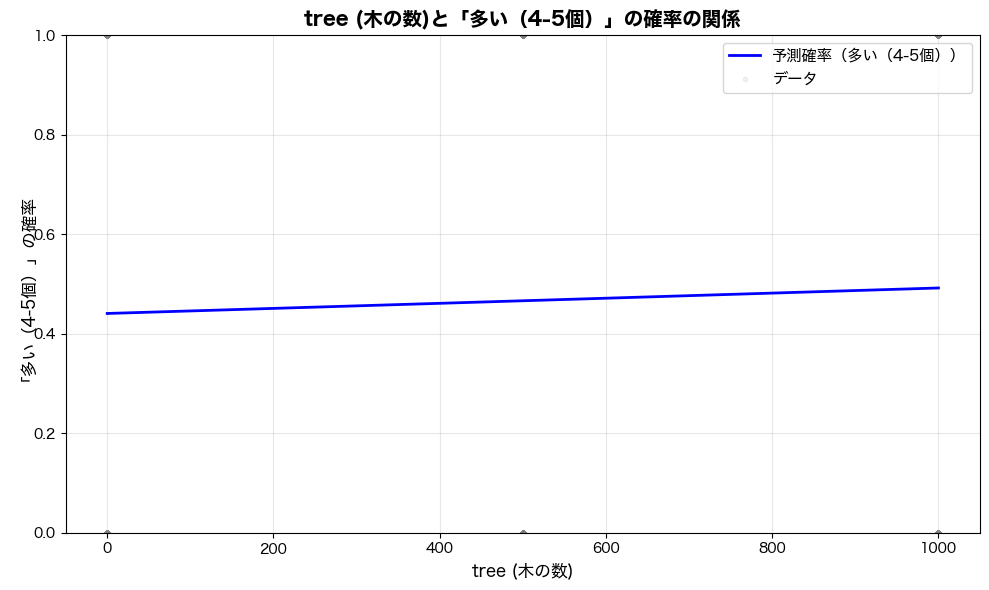

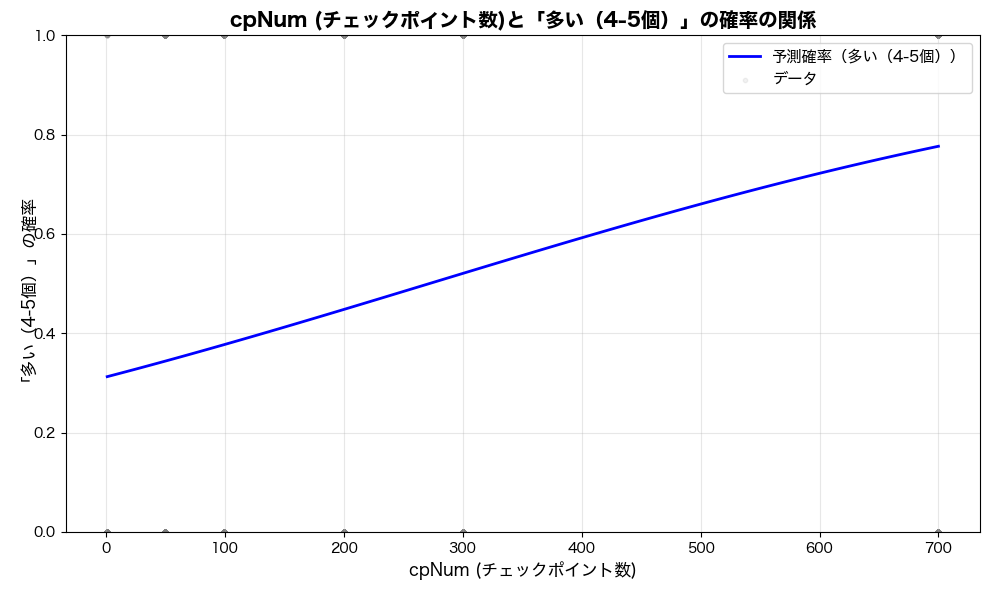

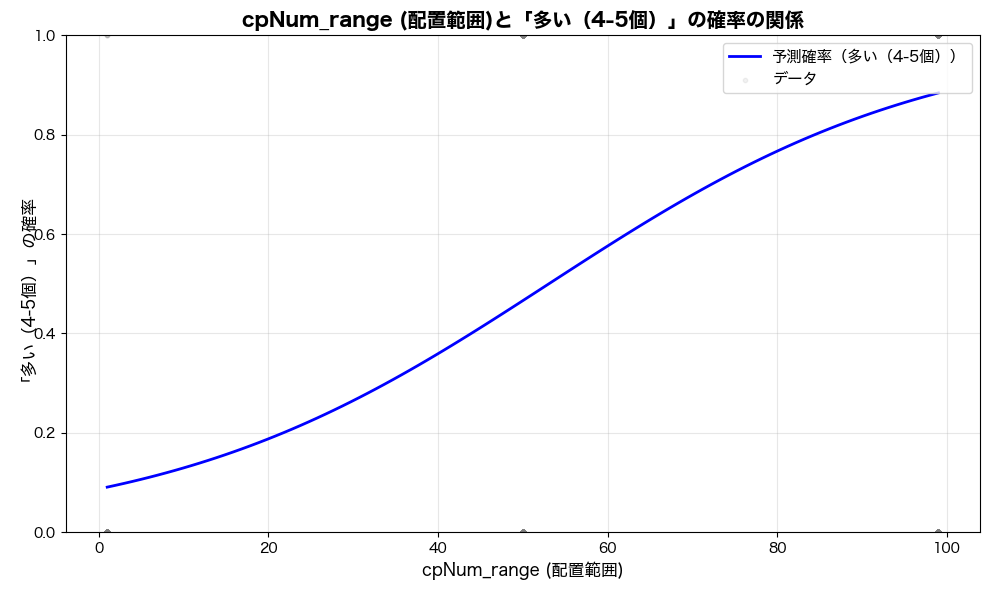

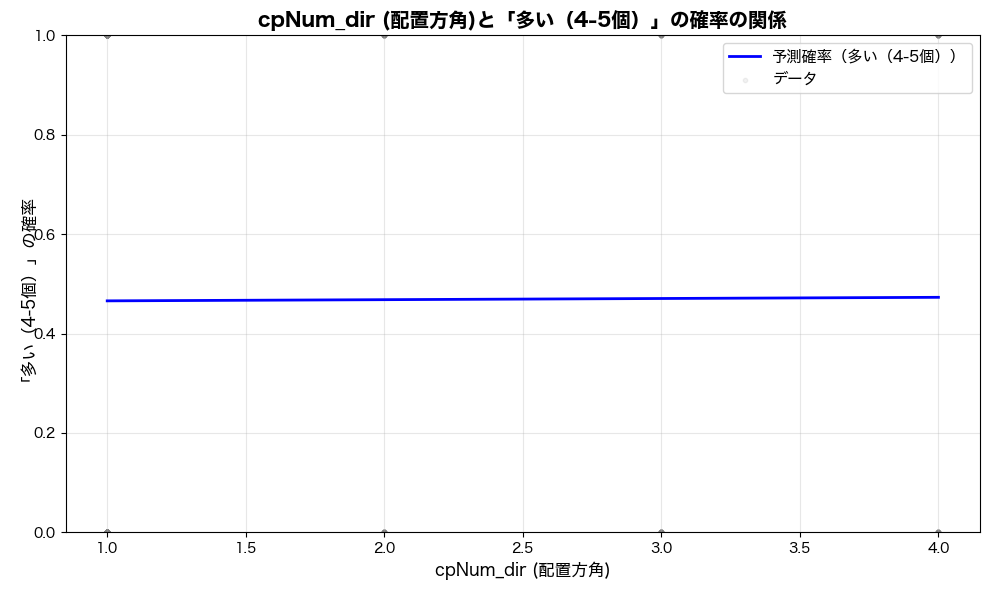

In [594]:
# ロジスティック回帰曲線の可視化（各説明変数ごとに別々の画像）
print("\n" + "="*70)
print("ロジスティック回帰曲線（バグ発見数の2クラス分類）")
print("="*70)

# 各変数の平均値
mean_tree_binary = df_bug_count_binary['tree'].mean()
mean_cpNum_binary = df_bug_count_binary['cpNum'].mean()
mean_cpNum_range_binary = df_bug_count_binary['cpNum_range'].mean()
mean_cpNum_dir_binary = df_bug_count_binary['cpNum_dir'].mean()

variables = ['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']
var_labels = ['tree (木の数)', 'cpNum (チェックポイント数)', 'cpNum_range (配置範囲)', 'cpNum_dir (配置方角)']
mean_values = [mean_tree_binary, mean_cpNum_binary, mean_cpNum_range_binary, mean_cpNum_dir_binary]

# 2クラス分類用のラベル（多い（4-5個）を1、少ない（0-3個）を0に変換）
y_binary_numeric = (df_bug_count_binary['bug_count_category_binary'] == '多い（4-5個）').astype(int)

for var, label, mean_val in zip(variables, var_labels, mean_values):
    # 変数の範囲を取得
    var_min = df_bug_count_binary[var].min()
    var_max = df_bug_count_binary[var].max()
    var_range = np.linspace(var_min, var_max, 100)
    
    # 予測確率を計算
    predictions = []
    for val in var_range:
        # 他の変数は平均値に固定
        X_pred = pd.DataFrame({
            'tree': [mean_tree_binary if var != 'tree' else val],
            'cpNum': [mean_cpNum_binary if var != 'cpNum' else val],
            'cpNum_range': [mean_cpNum_range_binary if var != 'cpNum_range' else val],
            'cpNum_dir': [mean_cpNum_dir_binary if var != 'cpNum_dir' else val]
        })
        # 標準化
        X_pred_scaled = scaler_binary.transform(X_pred)
        # 予測確率（多い（4-5個）の確率）
        pred_prob = lr_model_binary.predict_proba(X_pred_scaled)[0, 0]
        predictions.append(pred_prob)
    
    # 個別のグラフを描画
    plt.figure(figsize=(10, 6))
    plt.plot(var_range, predictions, 'b-', linewidth=2, label='予測確率（多い（4-5個））')
    plt.scatter(df_bug_count_binary[var], y_binary_numeric, alpha=0.1, s=10, c='gray', label='データ')
    plt.xlabel(label, fontsize=12)
    plt.ylabel('「多い（4-5個）」の確率', fontsize=12)
    plt.title(f'{label}と「多い（4-5個）」の確率の関係', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=11)
    plt.ylim([0, 1])
    plt.tight_layout()
    plt.show()


In [595]:
# 2クラス分類のロジスティック回帰の係数と式の表示

print("="*70)
print("【バグ発見数の2クラス分類：ロジスティック回帰の係数と式】")
print("="*70)

# モデルの係数と切片を取得
coefficients_binary = lr_model_binary.coef_[0]  # 1次元配列
intercept_binary = lr_model_binary.intercept_[0]  # スカラー
feature_names = ['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']

# 標準化パラメータを取得
scaler_mean_binary = scaler_binary.mean_
scaler_scale_binary = scaler_binary.scale_

print("\n【標準化パラメータ】")
print("平均値:")
for i, name in enumerate(feature_names):
    print(f"  {name}: {scaler_mean_binary[i]:.4f}")
print("\n標準偏差:")
for i, name in enumerate(feature_names):
    print(f"  {name}: {scaler_scale_binary[i]:.4f}")

print("\n" + "="*70)
print("【標準化されたデータに対する係数】")
print("="*70)
print("（sklearnのモデルは標準化されたデータで学習されています）\n")
print(f"切片 (intercept): {intercept_binary:.6f}")
print("係数:")
for feat_idx, feat_name in enumerate(feature_names):
    print(f"  {feat_name}: {coefficients_binary[feat_idx]:.6f}")

print("\n" + "="*70)
print("【元のスケールでの係数（標準化の逆変換）】")
print("="*70)
print("（元のパラメータのスケールで直接使用できる式）\n")

# 標準化の逆変換: 元のスケールでの係数を計算
# 元のスケールでの係数 = 標準化された係数 / 標準偏差
orig_coef_binary = coefficients_binary / scaler_scale_binary

# 元のスケールでの切片 = 標準化された切片 - Σ(係数 * 平均 / 標準偏差)
orig_intercept_binary = intercept_binary - np.sum(coefficients_binary * scaler_mean_binary / scaler_scale_binary)

print(f"切片: {orig_intercept_binary:.6f}")
print("係数:")
for feat_idx, feat_name in enumerate(feature_names):
    print(f"  {feat_name}: {orig_coef_binary[feat_idx]:.6f}")

print("\n" + "="*70)
print("【ロジット関数（式）】")
print("="*70)
print("（元のパラメータのスケールで使用可能）\n")

# 1行の式として表示
formula_parts = [f"{orig_intercept_binary:.6f}"]
for feat_idx, feat_name in enumerate(feature_names):
    sign = " + " if orig_coef_binary[feat_idx] >= 0 else " - "
    abs_coef = abs(orig_coef_binary[feat_idx])
    formula_parts.append(f"{sign}{abs_coef:.6f} × {feat_name}")

formula = "".join(formula_parts)
print(f"logit = {formula}")

# より読みやすい形式でも表示
print(f"\n展開形式:")
print(f"logit = {orig_intercept_binary:.6f}", end="")
for feat_idx, feat_name in enumerate(feature_names):
    sign = " + " if orig_coef_binary[feat_idx] >= 0 else " - "
    abs_coef = abs(orig_coef_binary[feat_idx])
    print(f"{sign}{abs_coef:.6f} × {feat_name}", end="")
print()

print("\n" + "="*70)
print("【確率の計算式（ロジスティック関数）】")
print("="*70)
print("""
「多い（4-5個）」の確率は、ロジスティック関数で計算されます：

P(多い) = 1 / (1 + exp(-logit))

「少ない（0-3個）」の確率は：

P(少ない) = 1 - P(多い) = exp(-logit) / (1 + exp(-logit))

予測されるクラスは、P(多い) > 0.5 なら「多い（4-5個）」、そうでなければ「少ない（0-3個）」です。
""")

# 検証: 実際に計算して確認
print("\n" + "="*70)
print("【検証: 実際の計算例】")
print("="*70)

test_params = {
    'tree': 500,
    'cpNum': 200,
    'cpNum_range': 50,
    'cpNum_dir': 2
}

print(f"\nパラメータ: {test_params}")

# ロジットを計算
logit = orig_intercept_binary
logit += orig_coef_binary[0] * test_params['tree']
logit += orig_coef_binary[1] * test_params['cpNum']
logit += orig_coef_binary[2] * test_params['cpNum_range']
logit += orig_coef_binary[3] * test_params['cpNum_dir']

print(f"\n【ロジット計算】")
print(f"logit = {orig_intercept_binary:.6f}", end="")
print(f" + {orig_coef_binary[0]:.6f} × {test_params['tree']}", end="")
print(f" + {orig_coef_binary[1]:.6f} × {test_params['cpNum']}", end="")
print(f" + {orig_coef_binary[2]:.6f} × {test_params['cpNum_range']}", end="")
print(f" + {orig_coef_binary[3]:.6f} × {test_params['cpNum_dir']}")

# 計算結果を表示
term1 = orig_intercept_binary
term2 = orig_coef_binary[0] * test_params['tree']
term3 = orig_coef_binary[1] * test_params['cpNum']
term4 = orig_coef_binary[2] * test_params['cpNum_range']
term5 = orig_coef_binary[3] * test_params['cpNum_dir']
print(f"     = {term1:.6f} + {term2:.6f} + {term3:.6f} + {term4:.6f} + {term5:.6f}")
print(f"     = {logit:.6f}")

# 確率を計算
prob_many = 1 / (1 + np.exp(-logit))
prob_few = 1 - prob_many

print("\n計算された確率:")
print(f"  少ない（0-3個）: {prob_few:.4f} ({prob_few*100:.2f}%)")
print(f"  多い（4-5個）: {prob_many:.4f} ({prob_many*100:.2f}%)")

# モデルでの予測と比較
X_test_manual_binary = pd.DataFrame([test_params])
X_test_manual_binary_scaled = scaler_binary.transform(X_test_manual_binary)
pred_proba_manual_binary = lr_model_binary.predict_proba(X_test_manual_binary_scaled)[0]

print("\nモデルでの予測確率（検証用）:")
print(f"  少ない（0-3個）: {pred_proba_manual_binary[0]:.4f} ({pred_proba_manual_binary[0]*100:.2f}%)")
print(f"  多い（4-5個）: {pred_proba_manual_binary[1]:.4f} ({pred_proba_manual_binary[1]*100:.2f}%)")

print("\n（注: 標準化の逆変換による計算とモデルの予測が一致することを確認）")


【バグ発見数の2クラス分類：ロジスティック回帰の係数と式】

【標準化パラメータ】
平均値:
  tree: 487.2685
  cpNum: 227.5110
  cpNum_range: 50.0567
  cpNum_dir: 1.1464

標準偏差:
  tree: 407.3400
  cpNum: 235.8810
  cpNum_range: 39.7994
  cpNum_dir: 0.5693

【標準化されたデータに対する係数】
（sklearnのモデルは標準化されたデータで学習されています）

切片 (intercept): 0.128787
係数:
  tree: -0.083908
  cpNum: -0.686230
  cpNum_range: -1.760924
  cpNum_dir: -0.005431

【元のスケールでの係数（標準化の逆変換）】
（元のパラメータのスケールで直接使用できる式）

切片: 3.116737
係数:
  tree: -0.000206
  cpNum: -0.002909
  cpNum_range: -0.044245
  cpNum_dir: -0.009540

【ロジット関数（式）】
（元のパラメータのスケールで使用可能）

logit = 3.116737 - 0.000206 × tree - 0.002909 × cpNum - 0.044245 × cpNum_range - 0.009540 × cpNum_dir

展開形式:
logit = 3.116737 - 0.000206 × tree - 0.002909 × cpNum - 0.044245 × cpNum_range - 0.009540 × cpNum_dir

【確率の計算式（ロジスティック関数）】

「多い（4-5個）」の確率は、ロジスティック関数で計算されます：

P(多い) = 1 / (1 + exp(-logit))

「少ない（0-3個）」の確率は：

P(少ない) = 1 - P(多い) = exp(-logit) / (1 + exp(-logit))

予測されるクラスは、P(多い) > 0.5 なら「多い（4-5個）」、そうでなければ「少ない（0-3個）」です。


【検証: 実際の計算

In [596]:
# 2クラス分類の適合度評価指標

print("="*70)
print("【バグ発見数の2クラス分類】適合度評価指標")
print("="*70)

# ===== 1. statsmodelsを使用したロジスティック回帰（統計的評価のため） =====
print("\n" + "="*70)
print("【1. statsmodelsを使用したロジスティック回帰分析】")
print("="*70)

# 2クラス分類用のデータを準備（0-3個=0, 4-5個=1）
df_bug_count_binary_stats = df_bug_count_binary.copy()
df_bug_count_binary_stats['bug_count_binary'] = (df_bug_count_binary_stats['bug_count'] > 3).astype(int)

# statsmodelsを使用したロジスティック回帰
logit_model_binary_stats = smf.logit('bug_count_binary ~ tree + cpNum + cpNum_range + cpNum_dir', 
                                      data=df_bug_count_binary_stats)
logit_result_binary_stats = logit_model_binary_stats.fit(disp=0)

print(logit_result_binary_stats.summary())

# 係数の95%信頼区間を取得
conf_int_binary = logit_result_binary_stats.conf_int(alpha=0.05)
conf_int_binary.columns = ['95% CI Lower', '95% CI Upper']

# オッズ比とその95%信頼区間を計算
print("\n" + "="*70)
print("オッズ比（Odds Ratio）と95%信頼区間")
print("="*70)
odds_ratios_binary = np.exp(logit_result_binary_stats.params)
odds_ci_lower_binary = np.exp(conf_int_binary['95% CI Lower'])
odds_ci_upper_binary = np.exp(conf_int_binary['95% CI Upper'])

for var in logit_result_binary_stats.params.index:
    odds_ratio = odds_ratios_binary[var]
    ci_lower = odds_ci_lower_binary[var]
    ci_upper = odds_ci_upper_binary[var]
    
    print(f"\n  {var}:")
    print(f"    オッズ比: {odds_ratio:.4f}")
    print(f"    95%信頼区間: [{ci_lower:.4f}, {ci_upper:.4f}]")
    
    if odds_ratio > 1:
        print(f"    → {var}が1単位増加すると、「多い（4-5個）」のオッズが{(odds_ratio-1)*100:.2f}%増加")
    elif odds_ratio < 1:
        print(f"    → {var}が1単位増加すると、「多い（4-5個）」のオッズが{(1-odds_ratio)*100:.2f}%減少")

# ===== 2. Pseudo R-squared =====
print("\n" + "="*70)
print("【2. Pseudo R-squared (McFadden)】")
print("="*70)
print(f"Pseudo R-squared: {logit_result_binary_stats.prsquared:.4f}")
print(f"  → 0に近いほど適合度が低く、1に近いほど適合度が高い")
print(f"  → 0.2-0.4程度で実用的なモデルとされる")
print(f"  → 現在の値は{'良好' if logit_result_binary_stats.prsquared > 0.2 else 'やや低い'}")

# ===== 3. AIC/BIC =====
print("\n" + "="*70)
print("【3. AIC/BIC】")
print("="*70)
print(f"AIC (Akaike Information Criterion): {logit_result_binary_stats.aic:.2f}")
print(f"BIC (Bayesian Information Criterion): {logit_result_binary_stats.bic:.2f}")
print(f"  → 小さいほど良いモデル（モデル比較に使用）")

# ===== 4. 対数尤度と尤度比検定 =====
print("\n" + "="*70)
print("【4. 対数尤度と尤度比検定】")
print("="*70)
print(f"対数尤度 (Log-Likelihood): {logit_result_binary_stats.llf:.2f}")
print(f"Null対数尤度 (LL-Null): {logit_result_binary_stats.llnull:.2f}")
print(f"尤度比 (Likelihood Ratio): {logit_result_binary_stats.llr:.2f}")
print(f"尤度比検定 p-value (LLR p-value): {logit_result_binary_stats.llr_pvalue:.2e}")
print(f"  → LLR p-value < 0.05 なら、モデルはNullモデルより有意に優れている")
print(f"  → 現在のモデルは{'有意に優れている' if logit_result_binary_stats.llr_pvalue < 0.05 else '有意に優れていない'}")

# 尤度比の解釈
improvement_ratio_binary = (logit_result_binary_stats.llf - logit_result_binary_stats.llnull) / abs(logit_result_binary_stats.llnull)
print(f"\n尤度改善率: {improvement_ratio_binary:.4f}")
print(f"  → Nullモデルと比較して、対数尤度が{improvement_ratio_binary*100:.2f}%改善")

# ===== 5. Cohen's Kappa =====
print("\n" + "="*70)
print("【5. Cohen's Kappa（クラス不均衡を考慮）】")
print("="*70)
kappa_binary = cohen_kappa_score(y_test_binary, y_pred_binary)
print(f"Cohen's Kappa: {kappa_binary:.4f}")
print(f"  → 1に近いほど良い（0.6以上で実用的、0.8以上で優秀）")
print(f"  → 現在の値は{'優秀' if kappa_binary > 0.8 else '良好' if kappa_binary > 0.6 else 'やや低い' if kappa_binary > 0.4 else '改善の余地あり'}")

# ===== 6. Log Loss =====
print("\n" + "="*70)
print("【6. Log Loss（対数損失）】")
print("="*70)
log_loss_binary = log_loss(y_test_binary, y_pred_proba_binary, labels=lr_model_binary.classes_)
print(f"Log Loss: {log_loss_binary:.4f}")
print(f"  → 0に近いほど良い")
print(f"  → 現在の値は{'良好' if log_loss_binary < 0.5 else 'やや高い' if log_loss_binary < 1.0 else '改善の余地あり'}")


【バグ発見数の2クラス分類】適合度評価指標

【1. statsmodelsを使用したロジスティック回帰分析】
                           Logit Regression Results                           
Dep. Variable:       bug_count_binary   No. Observations:                 2160
Model:                          Logit   Df Residuals:                     2155
Method:                           MLE   Df Model:                            4
Date:                Thu, 11 Dec 2025   Pseudo R-squ.:                  0.3574
Time:                        13:17:18   Log-Likelihood:                -961.09
converged:                       True   LL-Null:                       -1495.6
Covariance Type:            nonrobust   LLR p-value:                3.768e-230
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -3.0932      0.194    -15.910      0.000      -3.474      -2.712
tree            0.0002      0.000      1.324      0.185   -8.88e-05     

## 5. 5回実行して5回バグ発見になるカテゴリ分析

二値分類モデルの適合度を評価します。

In [597]:
# 新しい分析: 全ての実行結果がバグ発見である確率を求めるロジスティック回帰
import os
import csv
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

def parse_directory_name_v2(dir_name):
    """
    ディレクトリ名をパースしてcpNum, cpNum_range, cpNum_dirを抽出
    """
    params = dir_name.split(',')
    if len(params) < 30:
        return None, None, None
    
    try:
        cpnum = None
        cpnum_range = None
        cpnum_dir = None
        
        # cpNum (0-9番目)
        for i in range(10):
            if int(params[i]) != 0:
                cpnum = int(params[i])
                break
        
        # cpNum_range (10-19番目)
        for i in range(10, 20):
            if int(params[i]) != 0:
                cpnum_range = int(params[i])
                break
        
        # cpNum_dir (20-29番目)
        for i in range(20, 30):
            if int(params[i]) != 0:
                cpnum_dir = int(params[i])
                break
        
        return cpnum, cpnum_range, cpnum_dir
    except (ValueError, IndexError):
        return None, None, None

def collect_aggregated_data(logs_root='Logs'):
    data_records = []
    logs_path = Path(logs_root)
    
    for tree_dir in logs_path.glob('tree=*'):
        try:
            tree_value = int(tree_dir.name.split('=')[1])
        except:
            continue
            
        for param_dir in tree_dir.iterdir():
            if not param_dir.is_dir():
                continue
            
            cpnum, cpnum_range, cpnum_dir = parse_directory_name_v2(param_dir.name)
            if cpnum is None or cpnum_range is None or cpnum_dir is None:
                continue
            
            detected_bugs_path = param_dir / 'detected_bugs.csv'
            if not os.path.exists(detected_bugs_path):
                continue
            
            # Read detected_bugs.csv
            # Check if all 5 executions are bugs (not null, not timeout)
            
            bug_count = 0
            total_executions = 0
            
            try:
                with open(detected_bugs_path, 'r') as f:
                    reader = csv.reader(f)
                    for row in reader:
                        total_executions += 1
                        if row != ['null'] and row != ['timeout']:
                            bug_count += 1
            except Exception as e:
                print(f"Error reading {detected_bugs_path}: {e}")
                continue
            
            if total_executions == 5:
                all_bugs = 1 if bug_count == 5 else 0
                data_records.append({
                    'tree': tree_value,
                    'cpNum': cpnum,
                    'cpNum_range': cpnum_range,
                    'cpNum_dir': cpnum_dir,
                    'all_bugs': all_bugs
                })
    
    return pd.DataFrame(data_records)

# データ収集
print("データを収集中...")
df_agg = collect_aggregated_data('Logs')
print(f"収集されたデータ数: {len(df_agg)}")
print("クラス分布:")
print(df_agg['all_bugs'].value_counts())

if len(df_agg) > 0:
    # ロジスティック回帰
    X = df_agg[['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']]
    y = df_agg['all_bugs']
    
    # データの分割
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # スケーリング
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # モデル学習
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)
    
    # 予測
    y_pred = model.predict(X_test_scaled)
    
    # 評価
    print("\n=== ロジスティック回帰分析結果 (全実行がバグ発見) ===")
    print("\n分類レポート:")
    print(classification_report(y_test, y_pred, target_names=['それ以外','全部バグ発見']))
    
    precision = precision_score(y_test, y_pred, pos_label=1)
    recall = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)
    print("\n単一指標 (陽性=1):")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-score : {f1:.4f}")
    
    # 係数の表示
    print("\n係数 (標準化後):")
    for name, coef in zip(X.columns, model.coef_[0]):
        print(f"{name}: {coef:.4f}")
    print(f"切片: {model.intercept_[0]:.4f}")
else:
    print("データが見つかりませんでした。")

データを収集中...
収集されたデータ数: 2160
クラス分布:
all_bugs
0    1397
1     763
Name: count, dtype: int64

=== ロジスティック回帰分析結果 (全実行がバグ発見) ===

分類レポート:
              precision    recall  f1-score   support

        それ以外       0.77      0.75      0.76       414
      全部バグ発見       0.58      0.60      0.59       234

    accuracy                           0.70       648
   macro avg       0.67      0.68      0.67       648
weighted avg       0.70      0.70      0.70       648


単一指標 (陽性=1):
Precision: 0.5785
Recall   : 0.5983
F1-score : 0.5882

係数 (標準化後):
tree: 0.1241
cpNum: 0.4624
cpNum_range: 1.3715
cpNum_dir: 0.0504
切片: -0.9024


In [598]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import numpy as np

# ベースラインモデルの予測を作成
# y_testのサイズに合わせて、すべて1（バグあり）またはすべて0（バグなし）の配列を作成
y_pred_always_bug = np.ones(len(y_test))
y_pred_always_no_bug = np.zeros(len(y_test))

print("="*70)
print("ベースラインモデルとの比較（バグ発見の有無）")
print("="*70)

# 1. ロジスティック回帰モデル（比較用）
print("【ロジスティック回帰モデル】")
print(classification_report(y_test, y_pred, target_names=['それ以外', '全部バグ発見']))
print("単一指標 (陽性=1):")
print(f"Precision: {precision_score(y_test, y_pred, pos_label=1):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred, pos_label=1):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred, pos_label=1):.4f}")
print("-" * 70)

# 2. 常にバグありと判定するモデル
print("【常にバグありと判定するモデル】")
# zero_division=0を指定して警告を抑制
print(classification_report(y_test, y_pred_always_bug, target_names=['それ以外', '全部バグ発見'], zero_division=0))
print("単一指標 (陽性=1):")
print(f"Precision: {precision_score(y_test, y_pred_always_bug, pos_label=1, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_always_bug, pos_label=1, zero_division=0):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred_always_bug, pos_label=1, zero_division=0):.4f}")
print("-" * 70)

# 3. 常にバグなしと判定するモデル
print("【常にバグなしと判定するモデル】")
print(classification_report(y_test, y_pred_always_no_bug, target_names=['それ以外', '全部バグ発見'], zero_division=0))
print("単一指標 (陽性=1):")
print(f"Precision: {precision_score(y_test, y_pred_always_no_bug, pos_label=1, zero_division=0):.4f}")
print(f"Recall   : {recall_score(y_test, y_pred_always_no_bug, pos_label=1, zero_division=0):.4f}")
print(f"F1-score : {f1_score(y_test, y_pred_always_no_bug, pos_label=1, zero_division=0):.4f}")
print("-" * 70)

ベースラインモデルとの比較（バグ発見の有無）
【ロジスティック回帰モデル】
              precision    recall  f1-score   support

        それ以外       0.77      0.75      0.76       414
      全部バグ発見       0.58      0.60      0.59       234

    accuracy                           0.70       648
   macro avg       0.67      0.68      0.67       648
weighted avg       0.70      0.70      0.70       648

単一指標 (陽性=1):
Precision: 0.5785
Recall   : 0.5983
F1-score : 0.5882
----------------------------------------------------------------------
【常にバグありと判定するモデル】
              precision    recall  f1-score   support

        それ以外       0.00      0.00      0.00       414
      全部バグ発見       0.36      1.00      0.53       234

    accuracy                           0.36       648
   macro avg       0.18      0.50      0.27       648
weighted avg       0.13      0.36      0.19       648

単一指標 (陽性=1):
Precision: 0.3611
Recall   : 1.0000
F1-score : 0.5306
----------------------------------------------------------------------
【常にバグなしと判定するモデル


【5回実行して5回バグ発見】ロジスティック回帰式

【ロジット関数（式）】
（元のパラメータのスケールで直接使用できる式）

logit = -3.279612 + 0.000302 × tree + 0.001954 × cpNum + 0.034050 × cpNum_range + 0.087582 × cpNum_dir

【展開形式】
logit = -3.279612 + 0.000302 × tree + 0.001954 × cpNum + 0.034050 × cpNum_range + 0.087582 × cpNum_dir

【確率関数】
P(全部バグ発見) = 1 / (1 + exp(-logit))
  = 1 / (1 + exp(-(-3.279612 + 0.000302 × tree + 0.001954 × cpNum + 0.034050 × cpNum_range + 0.087582 × cpNum_dir)))

オッズ比（Odds Ratio）
※元のスケール（標準化前）での1ユニット増加に対するオッズ比です

tree:
  オッズ比: 1.0003
  → treeが1ユニット増加すると、全部バグ発見のオッズが0.03%増加

cpNum:
  オッズ比: 1.0020
  → cpNumが1ユニット増加すると、全部バグ発見のオッズが0.20%増加

cpNum_range:
  オッズ比: 1.0346
  → cpNum_rangeが1ユニット増加すると、全部バグ発見のオッズが3.46%増加

cpNum_dir:
  オッズ比: 1.0915
  → cpNum_dirが1ユニット増加すると、全部バグ発見のオッズが9.15%増加


ロジスティック回帰曲線（5回実行して5回バグ発見）


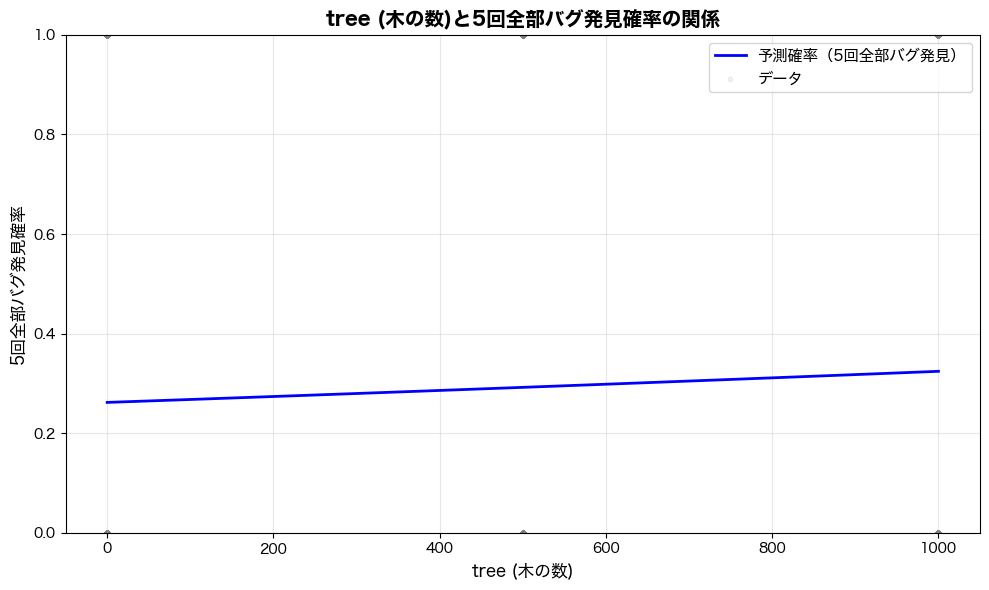

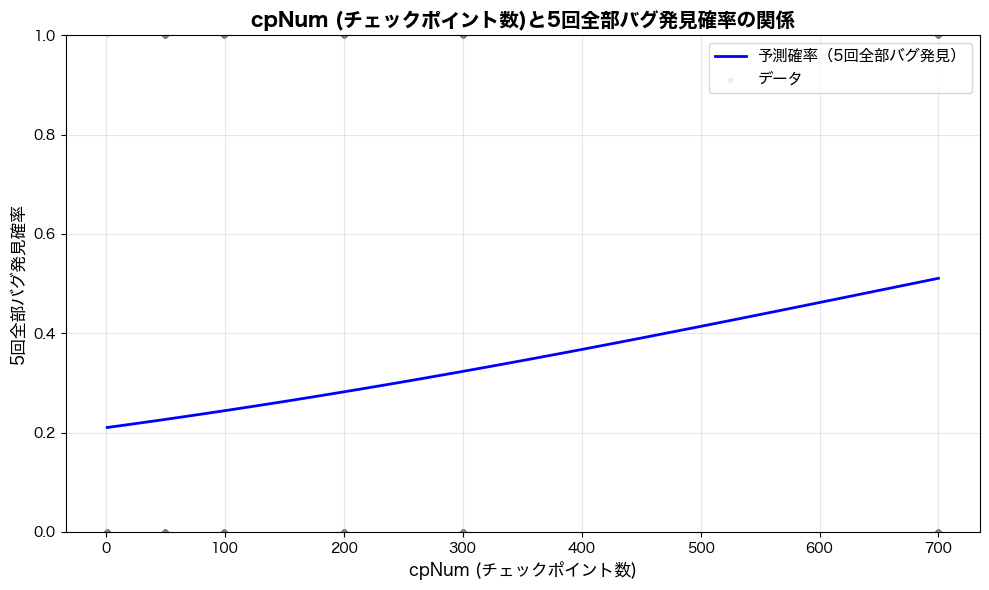

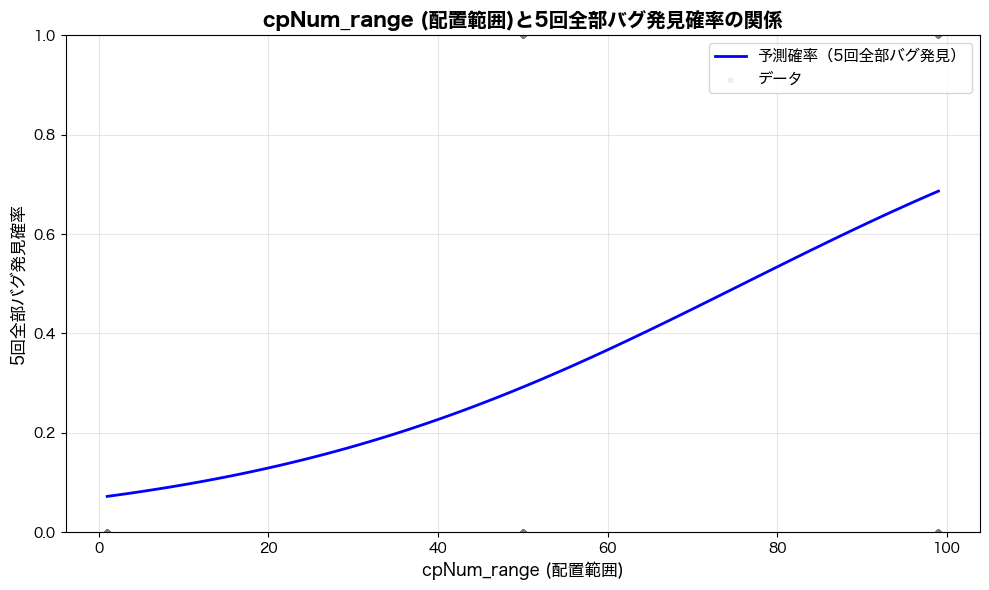

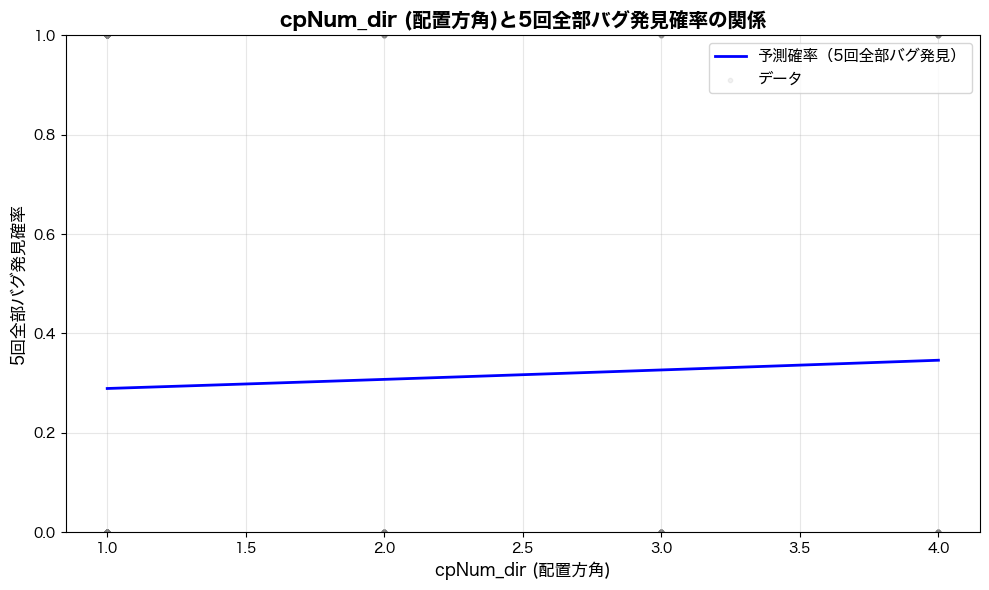

In [599]:
# ロジスティック回帰式の出力
if len(df_agg) > 0:
    print("\n" + "="*70)
    print("【5回実行して5回バグ発見】ロジスティック回帰式")
    print("="*70)
    
    # 係数を取得（標準化後）
    intercept_scaled = model.intercept_[0]
    coef_tree_scaled = model.coef_[0][0]
    coef_cpNum_scaled = model.coef_[0][1]
    coef_cpNum_range_scaled = model.coef_[0][2]
    coef_cpNum_dir_scaled = model.coef_[0][3]
    
    # 標準化パラメータを取得
    scaler_mean = scaler.mean_
    scaler_scale = scaler.scale_
    
    # 標準化の逆変換: 元のスケールでの係数を計算
    # 標準化: z = (x - mean) / scale
    # ロジット: logit = intercept + coef1*z1 + coef2*z2 + ...
    #         = intercept + coef1*(x1-mean1)/scale1 + coef2*(x2-mean2)/scale2 + ...
    #         = (intercept - Σ(coef_i * mean_i / scale_i)) + Σ(coef_i / scale_i * x_i)
    
    coefficients_scaled = np.array([coef_tree_scaled, coef_cpNum_scaled, coef_cpNum_range_scaled, coef_cpNum_dir_scaled])
    
    # 元のスケールでの係数 = 標準化された係数 / 標準偏差
    original_coef_tree = coef_tree_scaled / scaler_scale[0]
    original_coef_cpNum = coef_cpNum_scaled / scaler_scale[1]
    original_coef_cpNum_range = coef_cpNum_range_scaled / scaler_scale[2]
    original_coef_cpNum_dir = coef_cpNum_dir_scaled / scaler_scale[3]
    
    # 元のスケールでの切片 = 標準化された切片 - Σ(係数 * 平均 / 標準偏差)
    original_intercept = intercept_scaled - np.sum(coefficients_scaled * scaler_mean / scaler_scale)
    
    print("\n【ロジット関数（式）】")
    print("（元のパラメータのスケールで直接使用できる式）")
    print()
    
    formula_parts = [f"{original_intercept:.6f}"]
    if original_coef_tree != 0:
        sign = " + " if original_coef_tree >= 0 else " - "
        abs_coef = abs(original_coef_tree)
        formula_parts.append(f"{sign}{abs_coef:.6f} × tree")
    if original_coef_cpNum != 0:
        sign = " + " if original_coef_cpNum >= 0 else " - "
        abs_coef = abs(original_coef_cpNum)
        formula_parts.append(f"{sign}{abs_coef:.6f} × cpNum")
    if original_coef_cpNum_range != 0:
        sign = " + " if original_coef_cpNum_range >= 0 else " - "
        abs_coef = abs(original_coef_cpNum_range)
        formula_parts.append(f"{sign}{abs_coef:.6f} × cpNum_range")
    if original_coef_cpNum_dir != 0:
        sign = " + " if original_coef_cpNum_dir >= 0 else " - "
        abs_coef = abs(original_coef_cpNum_dir)
        formula_parts.append(f"{sign}{abs_coef:.6f} × cpNum_dir")
    
    formula = "".join(formula_parts)
    print(f"logit = {formula}")
    
    print("\n【展開形式】")
    print(f"logit = {original_intercept:.6f}", end="")
    if original_coef_tree != 0:
        sign = " + " if original_coef_tree >= 0 else " - "
        abs_coef = abs(original_coef_tree)
        print(f"{sign}{abs_coef:.6f} × tree", end="")
    if original_coef_cpNum != 0:
        sign = " + " if original_coef_cpNum >= 0 else " - "
        abs_coef = abs(original_coef_cpNum)
        print(f"{sign}{abs_coef:.6f} × cpNum", end="")
    if original_coef_cpNum_range != 0:
        sign = " + " if original_coef_cpNum_range >= 0 else " - "
        abs_coef = abs(original_coef_cpNum_range)
        print(f"{sign}{abs_coef:.6f} × cpNum_range", end="")
    if original_coef_cpNum_dir != 0:
        sign = " + " if original_coef_cpNum_dir >= 0 else " - "
        abs_coef = abs(original_coef_cpNum_dir)
        print(f"{sign}{abs_coef:.6f} × cpNum_dir", end="")
    print()
    
    print("\n【確率関数】")
    print("P(全部バグ発見) = 1 / (1 + exp(-logit))")
    print(f"  = 1 / (1 + exp(-({formula})))")
    
    # オッズ比の計算（元のスケールでの1ユニット増加に対する）
    print("\n" + "="*70)
    print("オッズ比（Odds Ratio）")
    print("="*70)
    print("※元のスケール（標準化前）での1ユニット増加に対するオッズ比です")
    print()
    
    # 各変数のオッズ比を計算（元のスケールでの係数を使用）
    variables_for_odds = ['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']
    original_coefficients = [original_coef_tree, original_coef_cpNum, original_coef_cpNum_range, original_coef_cpNum_dir]
    
    for var, orig_coef in zip(variables_for_odds, original_coefficients):
        if orig_coef != 0:
            odds_ratio_original = np.exp(orig_coef)
            print(f"{var}:")
            print(f"  オッズ比: {odds_ratio_original:.4f}")
            if odds_ratio_original > 1:
                print(f"  → {var}が1ユニット増加すると、全部バグ発見のオッズが{(odds_ratio_original-1)*100:.2f}%増加")
            elif odds_ratio_original < 1:
                print(f"  → {var}が1ユニット増加すると、全部バグ発見のオッズが{(1-odds_ratio_original)*100:.2f}%減少")
            else:
                print(f"  → {var}の変化は全部バグ発見のオッズに影響しない")
            print()

# ロジスティック回帰曲線の可視化（各説明変数ごとに別々の画像）
if len(df_agg) > 0:
    print("\n" + "="*70)
    print("ロジスティック回帰曲線（5回実行して5回バグ発見）")
    print("="*70)
    
    # 各変数の平均値（標準化前）
    mean_tree = df_agg['tree'].mean()
    mean_cpNum = df_agg['cpNum'].mean()
    mean_cpNum_range = df_agg['cpNum_range'].mean()
    mean_cpNum_dir = df_agg['cpNum_dir'].mean()
    
    variables = ['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']
    var_labels = ['tree (木の数)', 'cpNum (チェックポイント数)', 'cpNum_range (配置範囲)', 'cpNum_dir (配置方角)']
    mean_values = [mean_tree, mean_cpNum, mean_cpNum_range, mean_cpNum_dir]
    
    for var, label, mean_val in zip(variables, var_labels, mean_values):
        # 変数の範囲を取得（標準化前）
        var_min = df_agg[var].min()
        var_max = df_agg[var].max()
        var_range = np.linspace(var_min, var_max, 100)
        
        # 予測確率を計算
        predictions = []
        for val in var_range:
            # 他の変数は平均値に固定（標準化前の値）
            X_pred = pd.DataFrame({
                'tree': [mean_tree if var != 'tree' else val],
                'cpNum': [mean_cpNum if var != 'cpNum' else val],
                'cpNum_range': [mean_cpNum_range if var != 'cpNum_range' else val],
                'cpNum_dir': [mean_cpNum_dir if var != 'cpNum_dir' else val]
            })
            # 標準化してから予測
            X_pred_scaled = scaler.transform(X_pred)
            pred_prob = model.predict_proba(X_pred_scaled)[0][1]  # クラス1（全部バグ発見）の確率
            predictions.append(pred_prob)
        
        # 個別のグラフを描画
        plt.figure(figsize=(10, 6))
        plt.plot(var_range, predictions, 'b-', linewidth=2, label='予測確率（5回全部バグ発見）')
        plt.scatter(df_agg[var], df_agg['all_bugs'], alpha=0.1, s=10, c='gray', label='データ')
        plt.xlabel(label, fontsize=12)
        plt.ylabel('5回全部バグ発見確率', fontsize=12)
        plt.title(f'{label}と5回全部バグ発見確率の関係', fontsize=14, fontweight='bold')
        plt.grid(True, alpha=0.3)
        plt.legend(fontsize=11)
        plt.ylim([0, 1])
        plt.tight_layout()
        plt.show()

## 5-1. 5回実行して5回バグ発見：変数増減法による全変数組み合わせのF値計算

変数増減法を用いて、全ての変数の組み合わせでロジスティック回帰モデルを構築し、各組み合わせのF1スコアを計算します。
これにより、どの変数の組み合わせが最も予測性能が高いかを評価できます。

In [ ]:
# 変数増減法：全変数組み合わせでF値を計算（5回実行して5回バグ発見）
from itertools import combinations
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import StandardScaler

# 注意: このセルを実行する前に、X, y, X_train, X_test, y_train, y_testが定義されている必要があります
# これらの変数は、5回実行して5回バグ発見の分析セクションで既に定義されています

# 全ての変数の組み合わせを生成（空集合を含む）
variables = ['tree', 'cpNum', 'cpNum_range', 'cpNum_dir']
all_combinations = []

# 0個から4個までの全ての組み合わせを生成
for r in range(len(variables) + 1):
    for combo in combinations(variables, r):
        all_combinations.append(list(combo))

print("="*70)
print("【5回実行して5回バグ発見】変数増減法による全変数組み合わせのF値計算")
print("="*70)
print(f"\n総組み合わせ数: {len(all_combinations)}通り\n")

# 結果を格納するリスト
results = []

# 各組み合わせでモデルを構築し、F値を計算
for i, combo in enumerate(all_combinations, 1):
    if len(combo) == 0:
        # 空集合の場合は、常に多数派クラスを予測するモデル
        # 全部バグ発見が少数派なので、常に0を予測（それ以外）
        y_pred_combo = np.zeros(len(y_test))
        f1 = f1_score(y_test, y_pred_combo, pos_label=1, zero_division=0)
        precision = precision_score(y_test, y_pred_combo, pos_label=1, zero_division=0)
        recall = recall_score(y_test, y_pred_combo, pos_label=1, zero_division=0)
        accuracy = accuracy_score(y_test, y_pred_combo)
        combo_str = "（定数モデル：常にそれ以外）"
    else:
        # 選択された変数でモデルを構築
        X_train_combo = X_train[combo]
        X_test_combo = X_test[combo]
        
        # 標準化
        scaler_combo = StandardScaler()
        X_train_combo_scaled = scaler_combo.fit_transform(X_train_combo)
        X_test_combo_scaled = scaler_combo.transform(X_test_combo)
        
        # ロジスティック回帰モデルの学習
        lr_model_combo = LogisticRegression(random_state=42, max_iter=1000)
        lr_model_combo.fit(X_train_combo_scaled, y_train)
        
        # 予測
        y_pred_combo = lr_model_combo.predict(X_test_combo_scaled)
        
        # 評価指標
        f1 = f1_score(y_test, y_pred_combo, pos_label=1)
        precision = precision_score(y_test, y_pred_combo, pos_label=1)
        recall = recall_score(y_test, y_pred_combo, pos_label=1)
        accuracy = accuracy_score(y_test, y_pred_combo)
        combo_str = ", ".join(combo)
    
    # 結果を保存
    results.append({
        '組み合わせ番号': i,
        '変数の組み合わせ': combo_str,
        '変数の数': len(combo),
        'F1スコア': f1,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy
    })
    
    # 進捗表示（5件ごと、または重要な組み合わせ）
    if i % 5 == 0 or len(combo) <= 1 or len(combo) == len(variables):
        print(f"{i:2d}. 変数: {combo_str:40s} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | Accuracy: {accuracy:.4f}")

# 結果をDataFrameに変換
results_df = pd.DataFrame(results)

# F1スコアでソート
results_df_sorted = results_df.sort_values('F1スコア', ascending=False)

print("\n" + "="*70)
print("【結果サマリー】F1スコア順（上位10件）")
print("="*70)
print(results_df_sorted.head(10).to_string(index=False))

print("\n" + "="*70)
print("【結果サマリー】変数の数ごとの最高F1スコア")
print("="*70)
for num_vars in range(len(variables) + 1):
    subset = results_df[results_df['変数の数'] == num_vars]
    if len(subset) > 0:
        best = subset.loc[subset['F1スコア'].idxmax()]
        print(f"\n変数の数: {num_vars}")
        print(f"  最高F1スコア: {best['F1スコア']:.4f}")
        print(f"  変数の組み合わせ: {best['変数の組み合わせ']}")
        print(f"  Precision: {best['Precision']:.4f}, Recall: {best['Recall']:.4f}, Accuracy: {best['Accuracy']:.4f}")

# 全ての結果を表示
print("\n" + "="*70)
print("【全結果】F1スコア順")
print("="*70)
print(results_df_sorted.to_string(index=False))

# 結果をCSVファイルに保存（オプション）
# results_df_sorted.to_csv('variable_selection_results_5times_bug.csv', index=False, encoding='utf-8-sig')
# print("\n結果を 'variable_selection_results_5times_bug.csv' に保存しました。")

【5回実行して5回バグ発見】変数増減法による全変数組み合わせのF値計算

総組み合わせ数: 16通り

 1. 変数: （定数モデル：常にそれ以外）                           | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | Accuracy: 0.6389
 2. 変数: tree                                     | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | Accuracy: 0.6389
 3. 変数: cpNum                                    | F1: 0.2703 | Precision: 0.4545 | Recall: 0.1923 | Accuracy: 0.6250
 4. 変数: cpNum_range                              | F1: 0.5519 | Precision: 0.5708 | Recall: 0.5342 | Accuracy: 0.6867
 5. 変数: cpNum_dir                                | F1: 0.0000 | Precision: 0.0000 | Recall: 0.0000 | Accuracy: 0.6389
10. 変数: cpNum, cpNum_dir                         | F1: 0.2703 | Precision: 0.4545 | Recall: 0.1923 | Accuracy: 0.6250
15. 変数: cpNum, cpNum_range, cpNum_dir            | F1: 0.6053 | Precision: 0.5804 | Recall: 0.6325 | Accuracy: 0.7022
16. 変数: tree, cpNum, cpNum_range, cpNum_dir      | F1: 0.5882 | Precision: 0.5785 | Recall: 0.5983 | Accuracy: 0.6975

【結果

/Users/yamaguchiyusei/programming/localfuzz_analysis/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/yamaguchiyusei/programming/localfuzz_analysis/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/yamaguchiyusei/programming/localfuzz_analysis/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavio